## 04g - Vertex AI > Pipelines - Forecasting Tournament with Kubeflow (KFP) and BQML + AutoML + Prophet

Throughtout the `04` series, different focasting platforms have been demostrated: BigQuery ML ARIMA+, Vertex AI AutoML Forecasting, and Custom Jobs using Prophet.  This notebook, `04g`, looks at the question "How do I pick the best approach?".  A great way to do this is using Vertex AI Pipelines, a service that can run Kubeflow pipelines (KFP).  In this notebook a number of custom pipeline components will be constructed to run each of the platforms with multiple scenarios and do custom metric calculations to pick the best overall platform + scenario and the best platform/scenario for each individual time series (stations for Citibike rentals).  This is a forecasting tournament!

It might be helpful to first review the previous notebooks in the `04` series to better understand each platform.

This notebook creates a BigQuery dataset to hold all the tables needed by the tournament.  The start of the notebook shows preparing the forecasting data source and storing it in the new dataset as a table named `source` and then creating a version with standardized columns names called `forecast_input`. The pipeline just needs the dataset name and `forecast_input` table to run all the methods.  The results are stored in tables within the same dataset.  Here is an overview of the data architecture:

<img src="architectures/overview/04g_Overview.png">

### Prerequisites:
This notebook has been made and independent as possible within this repository to help with using it as a starting point with your own data.  Hints have been given throughout on where to customize.  The only primary dependency from the other notebook in this repository is the installation of Python package KFP in the `00 - Environment Setup` Notebook that can be completed here by running `!pip install kfp -U -q` prior to running this notebook.

For Understanding:
- the data used here it may be helpful to review:
    -  04 - Time Series Forecasting - Data Review in BigQuery
- the Methods used here it may be helpfult to review:
    - 04a - BigQuery Machine Learning (BQML) - Univariate Forecasting with ARIMA+
    - 04b - Vertex AI - AutoML for Global Forecasting with Deep Learning - In GCP Console (no code)
    - 04c - Vertex AI - AutoML for Global Forecasting with Deep Learning - with Python client (code)
    - 04d - Vertex AI - AutoML for Global Forecasting with Deep Learning - multiple parallel scenarios
    - 04e - Vertex AI > Notebooks - Forecasting with Prophet (Python)
    - 04f - Vertex AI > Training > Custom Jobs - Forecasting with Prophet using Custom Container


---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04g_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04g_console.png">

---
## How To Use This Notebook
The notebook can be used by simply changing parameter values at key places.  Each of these places is indicated with (CUSTOMIZE HERE) in the heading.

### Notebook Inputs: (CUSTOMIZE HERE)

In [1]:
# CUSTOMIZE
PROJECT_ID = 'statmike-demo3'
REGION = 'us-central1'
NOTEBOOK = '04g'

---
## Setup

Environment Check:

In [2]:
!gcloud config list project

[core]
project = statmike-demo3

Your active configuration is: [default]


packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform

from typing import NamedTuple
import kfp # used for dsl.pipeline
import kfp.v2.dsl as dsl # used for dsl.component, dsl.Output, dsl.Input, dsl.Artifact, dsl.Model, ...

import matplotlib.pyplot as plt
from datetime import datetime
import json

clients:

In [4]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bigquery = bigquery.Client(project = PROJECT_ID)

derived parameters:

In [5]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{NOTEBOOK}/models"
DIR = f"temp/{NOTEBOOK}"

BQ_DATASET = f"{NOTEBOOK}_tournament"

In [6]:
# Give service account roles/storage.objectAdmin permissions
# Console > IMA > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = ! gcloud config list --format='value(core.account)'[0]
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'715288179162-compute@developer.gserviceaccount.com'

local environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

GCP Configuaration Notes:

- The AutoML component will need to run 7 concurrent jobs in this example.
    - If you are just trying this out as a tutorial then update the list of CW values in the pipeline definition to only have <= 5 values: [32, 16, 8, 2, 0]
    - The default limit is 5 per: https://cloud.google.com/vertex-ai/docs/quotas#model_quotas
    - Update this to 10 with IAM > Quota using these instructions: https://cloud.google.com/docs/quota#requesting_higher_quota
    - This will require waiting on the update

---
## Prepare BigQuery Dataset and Table

The Vertex AI Pipeline created below prepares a BigQuery table for forecasting with multiple methods and creates output tables for each method as well as tables covering all methods.  This section creates the BigQuery Dataset and table of source data.

### Create BigQuery Dataset

In [8]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{BQ_DATASET}`
OPTIONS(
    location = 'US',
    labels = [('notebook','{NOTEBOOK}')]
)
"""
job = bigquery.query(query = query)
job.result()

### Create Source Table (BigQuery): forecast_source
A local set of data for the forecasting project - likely a subset of rows and columns that might include results from joining for multiple sources.   

In [9]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name, starttime, tripduration, usertype, gender, start_station_latitude, start_station_longitude
        FROM `bigquery-public-data.new_york.citibike_trips`
        WHERE start_station_name LIKE '%Central Park%'
    ),
    STATION_INFO AS (
        SELECT
            name, max(capacity) as capacity
        FROM `bigquery-public-data.new_york.citibike_stations`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

3.431

### Create Prep Table (BigQuery): forecast_prep

This is the SQL query that prepare the source data for forecasting by aggregating to the desired time granularity and preparing covariates and target values by summarizing.

That means preparing the `TIME_COLUMN` to the preferred time/date level expressed by `TIME_GRANULARITY`.  Helpful SQL functions for creating the time/date level are:
- [DATE_TRUNC](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#date_trunc): DATE_TRUNC(date_expression, date_part) where date_part = (DAY, WEEK, WEEK(SUNDAY), ISOWEEK, MONTH, QUARTER, YEAR, ISOYEAR)
- [TIME_TRUNC](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#time_trunc): TIME_TRUNC(time_expression, time_part) where time_part = (MICROSECOND, MILLISECOND, SECOND, MINUTE, HOUR)
- Extracting the part of a TIMESTAMP needed can be accomplished with EXTRACT(DATE/TIME from columnname)

The `TARGET_COLUMN` and `COV_UNAVAILABLE` and `COV_AVAILABLE` columns will need to be aggregated for the `TIME_GRANULARITY` using SQL functions like COUNT, SUM, AVG.

NOTE: When creating the `TARGET_COLUMN` variable this CAST the data to `INT64`.  If the `TARGET_COLUMN` needs to be `FLOAT64` then the components will need updating to handle the inserts to the output tables which expect `INT64`.

In [10]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_prep` AS
SELECT
   start_station_name,
   DATE_TRUNC(EXTRACT(DATE from starttime), DAY) as starttime,
   CAST(COUNT(*) as INT64) AS num_trips,
   start_station_latitude, start_station_longitude, max(capacity) as capacity,
   AVG(tripduration) as avg_tripduration,
   COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
   SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_source`
GROUP BY start_station_name, starttime, start_station_latitude, start_station_longitude   
ORDER BY start_station_name, starttime
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.223

### Source Data Parameters
The columns in the prepared data (next step below) will be categorized by their usage in forecasting:
- TARGET_COLUMN: name of the column containing the metric being tracked over time for forecasting
- TIME_COLUMN: name of the column containing the date/time of the records
- SERIES_COLUMN: name of the column that identifies the individual series of target values being tracked over time
- COV_UNAVAILABLE: a list of column names for columns representing covariates whose value cannot be known at forecast time
    - can be empty: []
    - examples: weather, traffic, view, number in carts, price rank/ratio
- COV_AVAILABLE: a list of column names for columns representing covariates whose value can be known at forecast time
    - can be empty: []
    - examples: quantity available, holiday, promotion, discount, price
- COV_ATTRIBUTE: a list of column names for columns representing static attributes for the individual series
    - can be empty: []
    - examples: characteristics of the time series like color, size, location
- TIME_GRANULARITY: the time aggregation level: minute, hour, day, week, month, year

In [11]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COV_UNAVAILABLE = ['avg_tripduration', 'pct_subscriber', 'ratio_gender']
COV_AVAILABLE = []
COV_ATTRIBUTE = ['start_station_latitude', 'start_station_longitude', 'capacity']
TIME_GRANULARITY = 'DAY'

### Review Time Series: forecast_prep

In [12]:
query = f"""
SELECT 
    {SERIES_COLUMN},
    COUNT(*) as records, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
GROUP BY {SERIES_COLUMN}
ORDER BY {SERIES_COLUMN}
"""
overview = bigquery.query(query = query).to_dataframe()

query = f"""
SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
"""
dates = bigquery.query(query = query).to_dataframe()

Visualize each series data/time range:

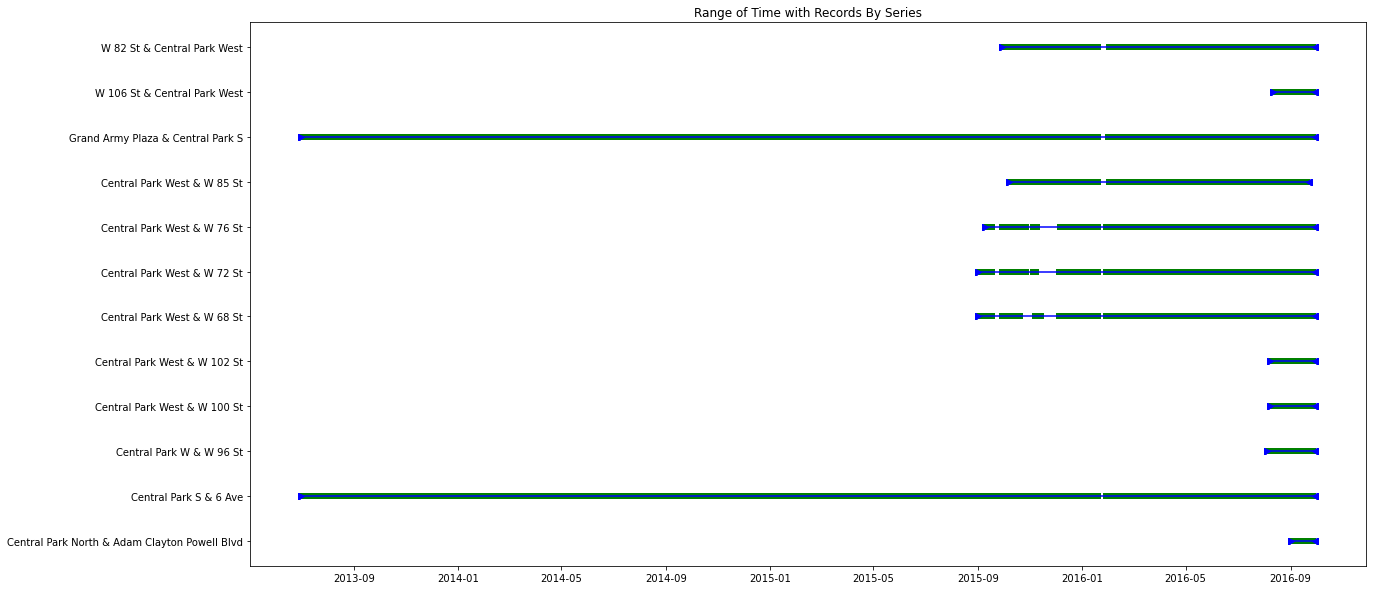

In [13]:
plt.figure(figsize=(20,10))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, '.-b')
    plt.scatter(dates[TIME_COLUMN], dates[SERIES_COLUMN], c='g', marker='|')
    plt.scatter(overview['FromDate'], overview[SERIES_COLUMN], c='b', marker='>')
    plt.scatter(overview['ToDate'], overview[SERIES_COLUMN], c='b', marker='<')
    plt.title('Range of Time with Records By Series')
plt.show()

### Create Input Table (BigQuery): forecast_input
Filter The Series, if needed

Rules Examples:
- data for at least 1 of last 14 days: RECENT_SERIES
- data for at least 28 days (gaps ok): FILTER_SERIES

In [14]:
# CUSTOMIZE
RECENT_PERIODS = 14 # latest time range for which a SERIES_COLUMN value must have data in order to be included
MIN_PERIODS = 28 # the minimum number of TIME_COLUMN rows for a SERIES_COLUMN value

In [15]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_input` AS
WITH
  ALL_SERIES AS (
    SELECT {SERIES_COLUMN}, count({TARGET_COLUMN}) as counts, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
    GROUP BY {SERIES_COLUMN}
  ),
  RECENT_SERIES AS (
    SELECT {SERIES_COLUMN}, count({TARGET_COLUMN}) as recent_counts
    FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
    WHERE {TIME_COLUMN} >= DATE_SUB((select max({TIME_COLUMN}) from `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`), INTERVAL {RECENT_PERIODS} {TIME_GRANULARITY})
    GROUP BY {SERIES_COLUMN}
  ),
  FILTER_SERIES AS (
    SELECT {SERIES_COLUMN}
    FROM ALL_SERIES
    LEFT OUTER JOIN (SELECT * FROM RECENT_SERIES)
    USING ({SERIES_COLUMN})
    WHERE counts >= {MIN_PERIODS} and recent_counts > 0
  ),
  FILTERED_PREP AS (
    SELECT *
    FROM FILTER_SERIES
    LEFT OUTER JOIN (SELECT * FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`)
    USING ({SERIES_COLUMN})
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
    )
SELECT *
FROM FILTERED_PREP
WHERE {TARGET_COLUMN} is not NULL
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
job = bigquery.query(query = query)
job.result()

In [16]:
A = bigquery.query(query = f"SELECT COUNT(*) AS counter FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`").to_dataframe()['counter'].iloc[0]
A

4382

### Update Input Table (BigQuery): forecast_input

#### Handle Missing Timepoints and data:
Missing timepoints may be handled differently by different methods.  This section prepares the by inserting rows for the missing timepoints for any missing time within `SERIES_COLUMN` values after the first actual time and up to the most recent date obsereved in the data.

#### Fill in missing values:
The `TARGET_COLUMN` and covariates may have missing values from the recorded data and will definitely have missing values from the inserted missing timepoints.  This code also applies calculating to insert values for the missing information.  Depending on the data source and characteristics the value filled in may differ.  For instance, if a missing timepoint means there was no transaction at the time then a `TARGET_COLUMN` value of 0 is likely appropriate. In the case of `COV_ATTRIBUTES` just bringing the last know value forward sufficient (LOCF).  

In [17]:
# CUSTOMIZE
def filler(method, column):
    if method == 'LOCF':
        q = f",\nLAST_VALUE({column} IGNORE NULLS) OVER (PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS {column}"
        return q
    elif method == 'FILL0':
        q = f",\nCASE WHEN {column} IS NULL THEN 0 ELSE {column} END AS {column}"
        return q
        
query_target = filler('FILL0', TARGET_COLUMN)
query_cov = ""
for v in COV_UNAVAILABLE+COV_AVAILABLE+COV_ATTRIBUTE:
    query_cov += filler('LOCF', v)

    
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_input` AS
WITH
    # List of Series with Min(Date) with data
    ALL_SERIES AS (
        SELECT {SERIES_COLUMN}, MIN({TIME_COLUMN}) AS {TIME_COLUMN}
        FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`
        GROUP BY {SERIES_COLUMN}
    ),
    # List of Series With All Dates after Min(Date) with data
    DATELIST AS (
            SELECT A.{SERIES_COLUMN}, B.{TIME_COLUMN}
            FROM ALL_SERIES A
            JOIN (SELECT {TIME_COLUMN}
                        FROM UNNEST(GENERATE_DATE_ARRAY(
                                (SELECT MIN({TIME_COLUMN}) FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`),
                                (SELECT MAX({TIME_COLUMN}) FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`),
                                INTERVAL 1 {TIME_GRANULARITY}
                            )
                        ) AS {TIME_COLUMN}
                    ) B
            ON A.{TIME_COLUMN} <= B.{TIME_COLUMN}
    ),
    # An Expanded Input Dataset with All Dates since Min(date) - blanks for Covs and Target
    EXPAND AS (
        SELECT *
        FROM DATELIST
        LEFT OUTER JOIN (SELECT *, 'actual' AS ROW_SOURCE FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`)
        USING ({SERIES_COLUMN}, {TIME_COLUMN})
        ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
    ),
    # Fill in the Empty values for Covs and Target
    FILL_EMPTY AS (
        SELECT {SERIES_COLUMN}, {TIME_COLUMN}{query_target}{query_cov},
        CASE WHEN ROW_SOURCE IS NULL THEN 'inserted' ELSE ROW_SOURCE END AS ROW_SOURCE
        FROM EXPAND
    )
SELECT *
FROM FILL_EMPTY
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
job = bigquery.query(query = query)
job.result()

In [18]:
B = bigquery.query(query = f"SELECT COUNT(*) AS counter FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`").to_dataframe()['counter'].iloc[0]
print(f'Added {B-A} records due to missing dates')

Added 149 records due to missing dates


### Review Time Series: forecast_input

In [19]:
query = f"""
SELECT 
    {SERIES_COLUMN},
    COUNT(*) as records, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`
GROUP BY {SERIES_COLUMN}
ORDER BY {SERIES_COLUMN}
"""
overview = bigquery.query(query = query).to_dataframe()

query = f"""
SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`
"""
dates = bigquery.query(query = query).to_dataframe()

Visualize each series data/time range:

**NOTE** the previous gaps for each series are now filled

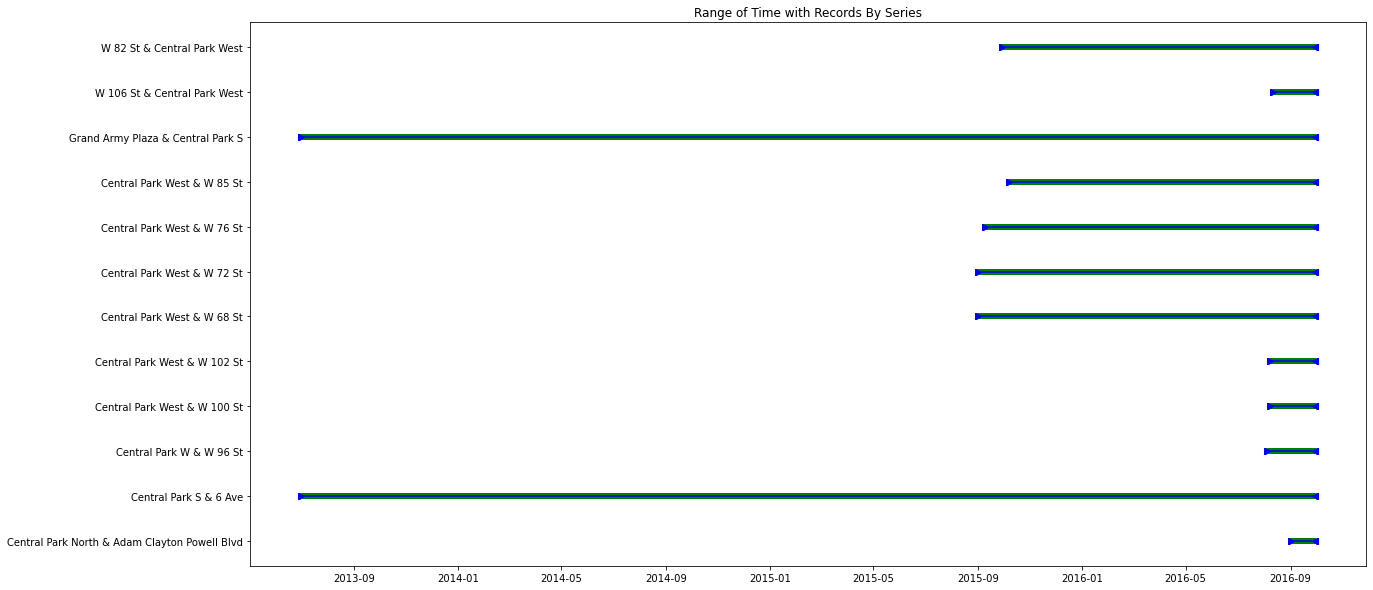

In [20]:
plt.figure(figsize=(20,10))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, '.-b')
    plt.scatter(dates[TIME_COLUMN], dates[SERIES_COLUMN], c='g', marker='|')
    plt.scatter(overview['FromDate'], overview[SERIES_COLUMN], c='b', marker='>')
    plt.scatter(overview['ToDate'], overview[SERIES_COLUMN], c='b', marker='<')
    plt.title('Range of Time with Records By Series')
plt.show()

### Review Time Series: forecast_input

In [21]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`
"""
rawSeries = bigquery.query(query = query).to_dataframe()

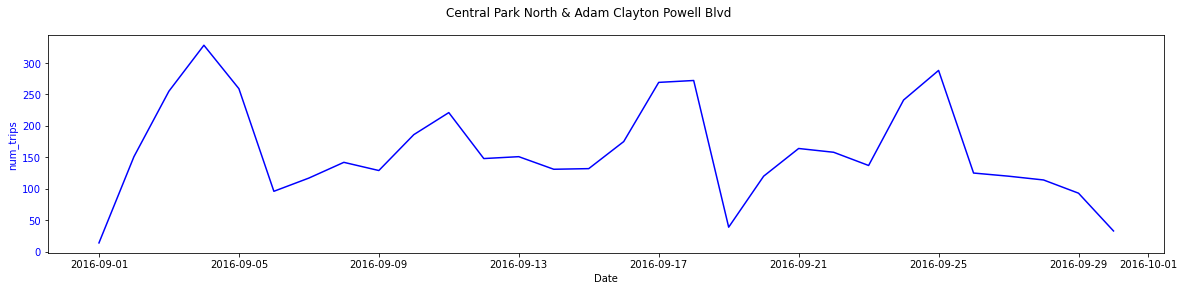

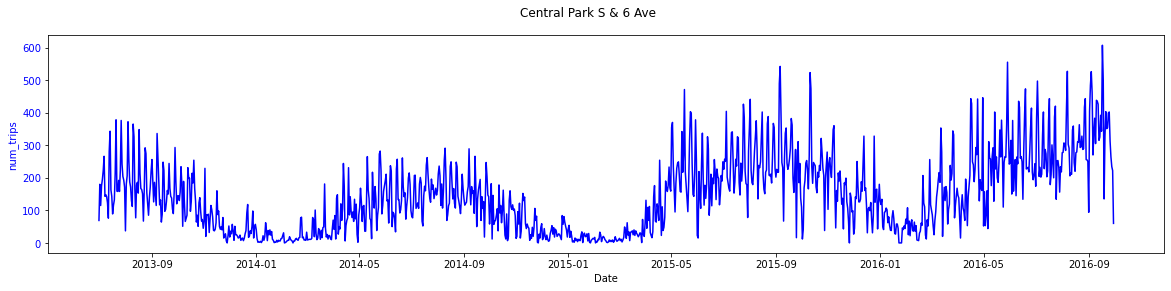

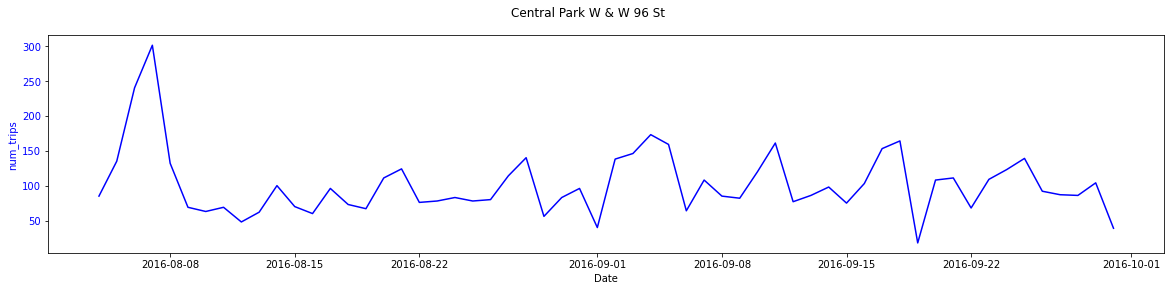

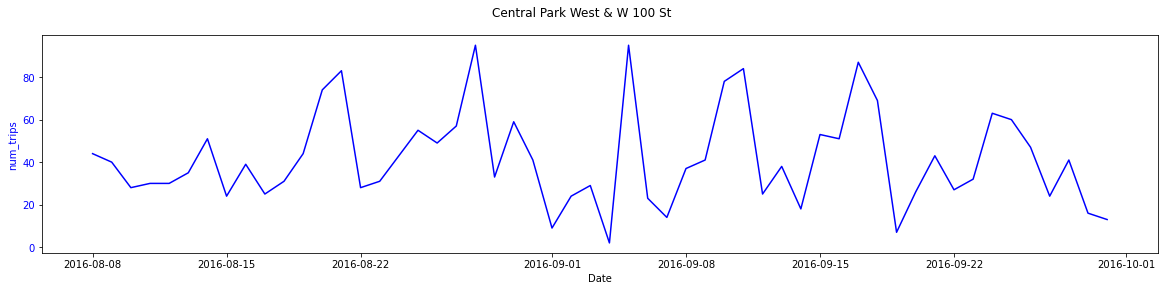

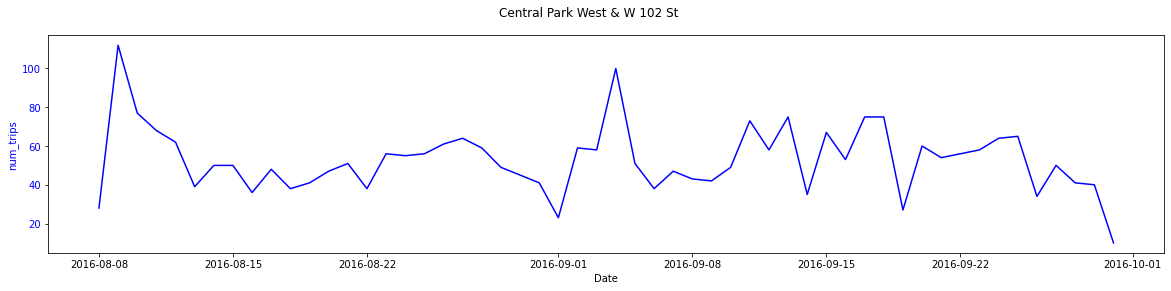

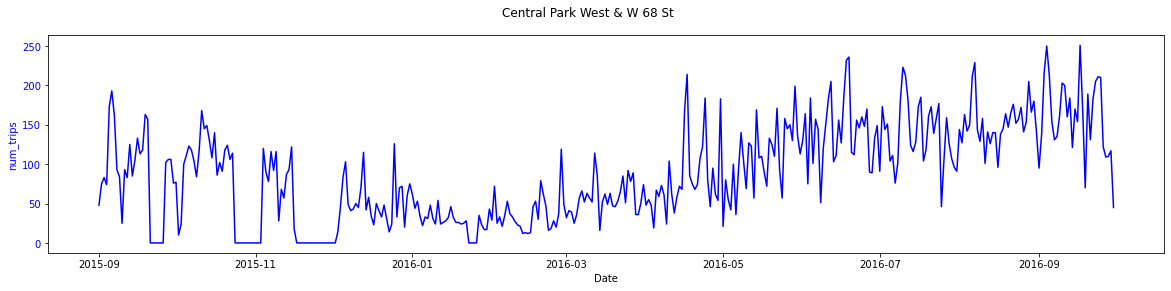

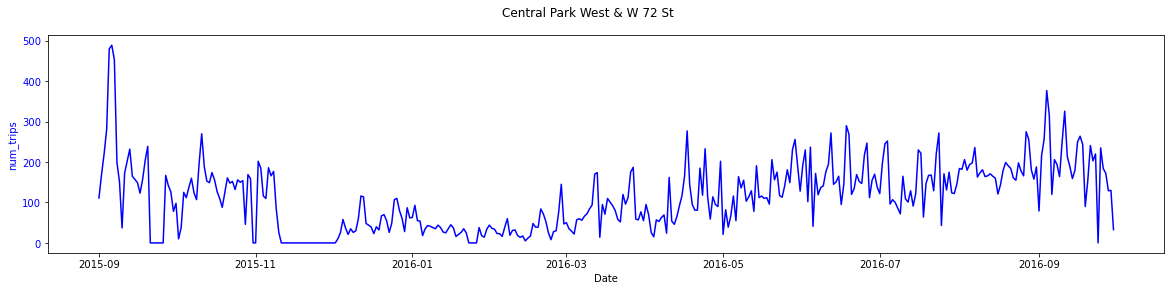

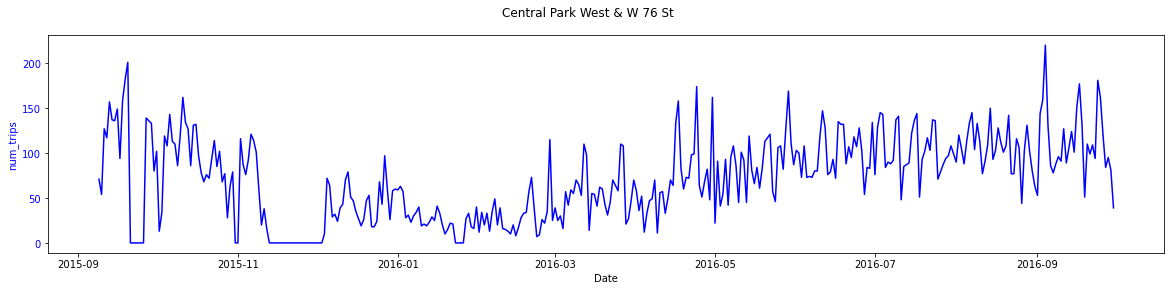

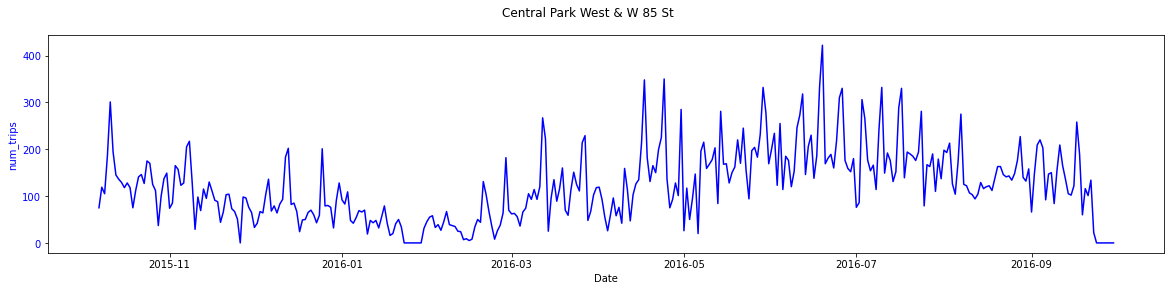

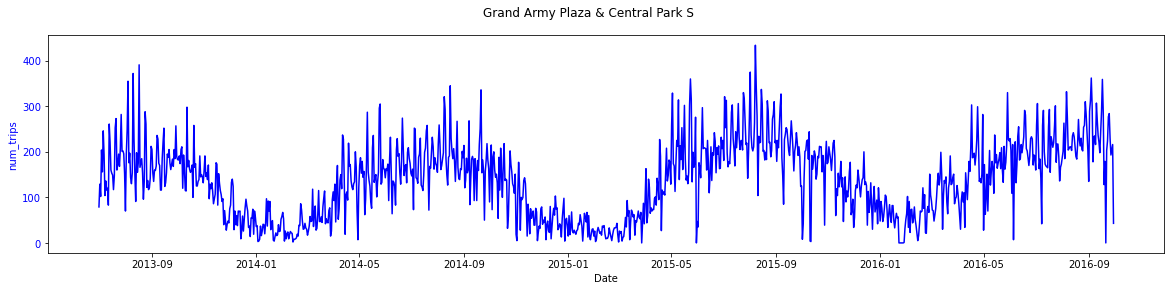

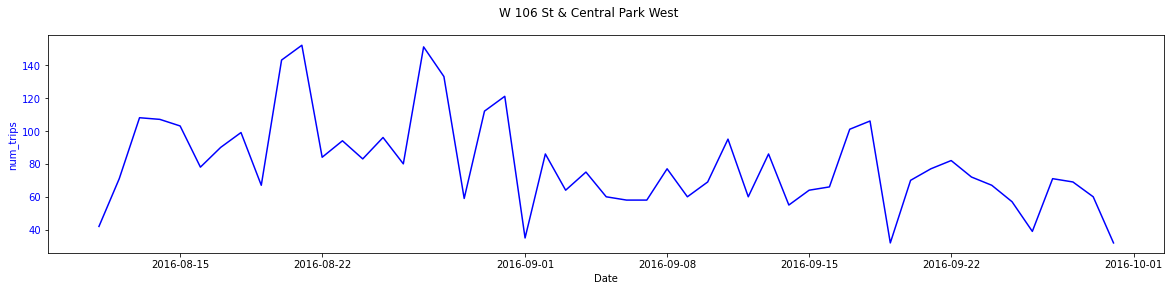

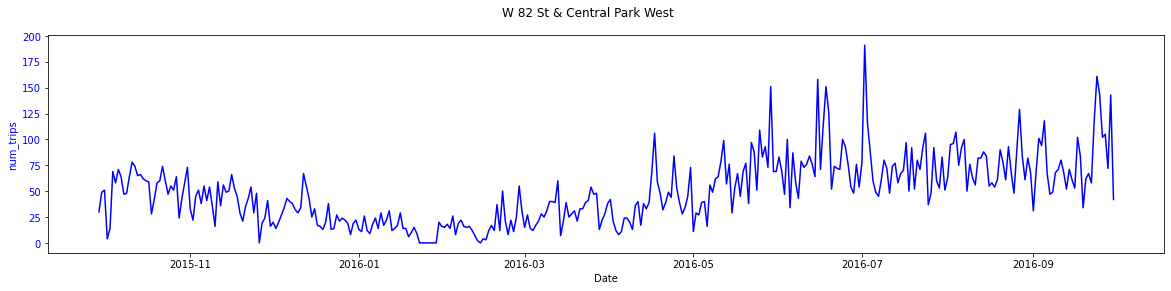

In [22]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    plotdf = rawSeries[(rawSeries[SERIES_COLUMN] == st)]
    fig, ax = plt.subplots(figsize=(20,4))
    ax.set_xlabel('Date')
    ax.set_ylabel(TARGET_COLUMN, color ='b')
    ax.tick_params(axis='y', labelcolor = 'b')
    ax.plot(plotdf[TIME_COLUMN], plotdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
    
    for c, cov in enumerate(COV_AVAILABLE):
        colors = ['g','c','m','b','r']
        if c<5:
            
            twin = ax.twinx()
            twin.set_ylabel(cov, color = colors[c])
            twin.tick_params(axis='y', labelcolor = colors[c])
            twin.spines.right.set_position(("axes", 1+.05*c))
            twin.plot(plotdf[TIME_COLUMN], plotdf[cov], color = colors[c], label = f'{cov}')
    
    plt.suptitle(st)
    plt.show()

---
## Custom Components (KFP)

Vertex AI Pipelines are made up of components that run independently with inputs and outputs that connect to form a graph - the pipeline.  For this notebook workflow the following custom components are used to orchestrate different forecasting approaches (BigQuery ML ARIMA+, Prophet, and Vertex AI AutoML Forecasting) and the different scenearios for each of these.

### Data Preparation
This component prepares the data for forecasting and adds the split column for Train/Validate/Test sets.  

In [23]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery', 'google-cloud-aiplatform']
)
def forecast_prep(
    project: str,
    region: str,
    notebook: str,
    bq_source: str,
    bq_dataset: str,
    forecast_granularity: str,
    forecast_test_length: int,
    forecast_val_length: int,
    forecast_horizon_length: int,
    max_context_window: int,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list
) -> NamedTuple('source', [('bq_input', str), ('bq_test', str), ('bq_horizon', str), ('bq_horizon_input', str), ('bq_input_query', str), ('dataset_resource_name', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_input', 'bq_test', 'bq_horizon', 'bq_horizon_input', 'bq_input_query', 'dataset_resource_name'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    bq_input = f'{project}.{bq_dataset}.forecast_input_pipeline'
    bq_test = f'{project}.{bq_dataset}.forecast_test'
    bq_horizon = f'{project}.{bq_dataset}.forecast_horizon'
    bq_horizon_input = f'{project}.{bq_dataset}.forecast_horizon_input'
    
    # Prepare forecast input
    queryTable = f"""
        CREATE OR REPLACE TABLE `{bq_input}` AS
        WITH
            FORECAST AS (
                SELECT {', '.join(cov_unavailable+cov_available+cov_attribute+[target_column, time_column, series_column])}, ROW_SOURCE
                FROM `{bq_source}`
            )
        SELECT *,
           CASE
               WHEN {time_column} > DATE_SUB((SELECT MAX({time_column}) FROM `{bq_source}`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
               WHEN {time_column} > DATE_SUB((SELECT MAX({time_column}) FROM `{bq_source}`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
               ELSE "TRAIN"
           END AS splits
        FROM FORECAST
        ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = queryTable)
    job.result()
    
    # Prepare Common Output Table for Test Data Fitted
    queryOutputTest = f"""
        CREATE OR REPLACE TABLE `{bq_test}`
        (platform STRING, method STRING, scenario STRING, {series_column} STRING, {time_column} DATE, {target_column} INT64, yhat FLOAT64, yhat_lower FLOAT64, yhat_upper FLOAT64)
    """
    job = bigquery.query(query = queryOutputTest)
    job.result()
    
    # create Vertex AI Dataset linking to bqtable
    dataset = aiplatform.TimeSeriesDataset.create(
        display_name = f'{bq_dataset}', 
        bq_source = f'bq://{bq_input}',
        labels = {'notebook':f'{notebook}'}
    )
    
    # Prepare Common Output Table For Future Data Forecasted
    queryOutputHorizon = f"""
        CREATE OR REPLACE TABLE `{bq_horizon}`
        (platform STRING, method STRING, scenario STRING, {series_column} STRING, {time_column} DATE, {target_column} INT64, yhat FLOAT64, yhat_lower FLOAT64, yhat_upper FLOAT64)
    """
    job = bigquery.query(query = queryOutputHorizon)
    job.result()
    
    # Prepare horizon table for forecasting (batch jobs for automl models) - includes max context_window (history from before the horizon)
    query_a = ""
    query_b = ""
    for v in cov_unavailable+cov_available+cov_attribute:
        query_a += f""",
                LAST_VALUE({v} IGNORE NULLS) OVER (PARTITION BY {series_column} ORDER BY {time_column} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as {v}"""
        if v not in cov_attribute:
            query_b += f""",
            CASE WHEN {time_column} > (SELECT MAX({time_column}) FROM `{bq_input}`) THEN NULL ELSE {v} END AS {v}"""
        else:
            query_b += f""",
            {v}"""
    query = f"""
    CREATE OR REPLACE TABLE `{bq_horizon_input}` AS
    WITH
        DATELIST AS (
            SELECT *
            FROM (SELECT DISTINCT {series_column} FROM `{bq_input}`) A
            CROSS JOIN (SELECT {time_column}
                        FROM UNNEST(GENERATE_DATE_ARRAY(
                                        DATE_SUB((SELECT MAX({time_column}) FROM `{bq_input}`), INTERVAL {max_context_window-1} {forecast_granularity}),
                                        DATE_ADD((SELECT MAX({time_column}) FROM `{bq_input}`), INTERVAL {forecast_horizon_length} {forecast_granularity}),
                                        INTERVAL 1 {forecast_granularity}
                                    )
                                ) AS {time_column}
                        ) B
        ),
        ADDTARGET AS (
            SELECT *
            FROM DATELIST
            LEFT OUTER JOIN (SELECT * FROM `{bq_input}`)
            USING ({series_column}, {time_column})
            ORDER BY {series_column}, {time_column}
        ),
        LOCF AS (
            SELECT {series_column}, {time_column},
            LAST_VALUE({target_column} IGNORE NULLS) OVER (PARTITION BY {series_column} ORDER BY {time_column} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as {target_column}{query_a}
            FROM ADDTARGET
        )
    SELECT {series_column}, {time_column},
        CASE WHEN {time_column} > (SELECT MAX({time_column}) FROM `{bq_input}`) THEN NULL ELSE {target_column} END AS {target_column}{query_b}
    FROM LOCF
    ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    return sources(bq_input, bq_test, bq_horizon, bq_horizon_input, queryTable, dataset.resource_name)

### BigQuery ML ARIMA+
This component fits a forecasting model using BigQuery ML model type ARIMA+.  This follows the logic used in notebook `04a`.

In [24]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery']
)
def forecast_bqarima(
    project: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    forecast_test_length: int,
    forecast_horizon_length: int,
    target_column: str,
    time_column: str,
    series_column: str,
    #cov_unavailable: list,
    #cov_available: list,
    #cov_attribute: list
) -> NamedTuple('source', [('bq_model', str), ('bq_model_query', str), ('bq_output', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_model', 'bq_model_query', 'bq_output', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameters
    table = bq_test.split('.')[-1]
    bq_model = f"{bq_test[:-(len(table)+1)]}.arimaplus"
    bq_output = f"{bq_test[:-(len(table)+1)]}.fitted_forecast_arimaplus"
    platform = 'BigQuery' 
    method = 'ARIMA_PLUS'
    scenario = 'automatic'
    
    # Create Model: ARIMA_PLUS
    # data_frequency should be ok as default = auto_frequency
    queryARIMA = f"""
        CREATE OR REPLACE MODEL `{bq_model}`
        OPTIONS
          (model_type = 'ARIMA_PLUS',
           time_series_timestamp_col = '{time_column}',
           time_series_data_col = '{target_column}',
           time_series_id_col = '{series_column}',
           auto_arima_max_order = 5,
           holiday_region = 'US',
           horizon = {forecast_test_length}+{forecast_horizon_length}
          ) AS
        SELECT {series_column}, {time_column}, {target_column}
        FROM `{bq_input}`
        WHERE splits in ('TRAIN','VALIDATE')
    """
    job = bigquery.query(query = queryARIMA)
    job.result()
    
    # Create Raw Output
    query = f"""
        CREATE OR REPLACE TABLE `{bq_output}` AS
        WITH
            FORECAST AS (
                SELECT
                    {series_column}, 
                    EXTRACT(DATE from time_series_timestamp) as {time_column},
                    time_series_adjusted_data as yhat,
                    prediction_interval_lower_bound as yhat_lower,
                    prediction_interval_upper_bound as yhat_upper
                FROM ML.EXPLAIN_FORECAST(MODEL `{bq_model}`, STRUCT({forecast_test_length+forecast_horizon_length} AS horizon, 0.95 AS confidence_level))
                WHERE time_series_type = 'forecast'
            ),
            ACTUAL AS (
                SELECT {series_column}, {time_column}, {target_column}, splits
                FROM `{bq_input}`
                WHERE splits = 'TEST'
            )
        SELECT {series_column}, {time_column}, {target_column}, yhat, yhat_lower, yhat_upper, splits
        FROM FORECAST
        LEFT OUTER JOIN ACTUAL
        USING ({series_column}, {time_column})
        ORDER BY {series_column}, {time_column} 
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bq_test}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_test}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            {series_column},
            {time_column},
            {target_column},
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits = 'TEST'
        ORDER by {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Insert forecast for future horizon
    query = f"""
        DELETE `{bq_horizon}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_horizon}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            {series_column},
            {time_column},
            {target_column},
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits is NULL
        ORDER by {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    return sources(bq_model, queryARIMA, bq_output, platform, method, scenario)

### Vertex AI AutoML Forecasting
This component fits a forecasting model using Vertex AI AutoML Forecasting.  This follows the logic used in notebooks `04c` and `04d`.

In [25]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['google-cloud-bigquery','google-cloud-aiplatform']
)
def forecast_automl(
    project: str,
    region: str,
    notebook: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    bq_horizon_input: str,
    dataset_rn: str, # vertex ai dataset.resource_name
    automl_max_time: int, # milli-node hours 1000 = 1 hour
    context_window: int, # context window
    forecast_granularity: str,
    forecast_granularity_count: int,
    forecast_test_length: int,
    forecast_horizon_length: int,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list
) -> NamedTuple('source', [('bq_output', str), ('model', str), ('batch_predictions', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_output', 'model', 'batch_predictions', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    table = bq_test.split('.')[-1]
    bq_dataset = bq_test.split('.')[1]
    bq_output = f"{bq_test[:-(len(table)+1)]}.fitted_forecast_automl_{context_window}"
    platform = 'Vertex AI' 
    method = 'AutoML'
    scenario = f'cw={context_window}'
    
    # dataset
    dataset = aiplatform.TimeSeriesDataset(dataset_rn)
    
    # Create Job
    column_specs = list(set(dataset.column_names) - set(['splits',series_column, 'ROW_SOURCE']))
    column_specs = dict.fromkeys(column_specs, 'auto') # timestamp, numerical, categorical, auto
    column_specs
    
    forecast_job = aiplatform.AutoMLForecastingTrainingJob(
        display_name = f'{bq_dataset}_automl_{context_window}',
        optimization_objective = "minimize-rmse",
        column_specs = column_specs,
        labels = {'notebook':f'{notebook}', 'cw': f'{context_window}'}
    )
    
    # Run Job
    forecast = forecast_job.run(
        dataset = dataset,
        target_column = target_column,
        time_column = time_column,
        time_series_identifier_column = series_column,
        unavailable_at_forecast_columns = [target_column]+cov_unavailable,
        available_at_forecast_columns = [time_column]+cov_available,
        time_series_attribute_columns = cov_attribute,
        forecast_horizon = forecast_horizon_length,
        data_granularity_unit = forecast_granularity,
        data_granularity_count = forecast_granularity_count,
        predefined_split_column_name = "splits",
        context_window = context_window,
        export_evaluated_data_items = True,
        export_evaluated_data_items_bigquery_destination_uri = f"bq://{bq_output.replace('.',':')}",
        export_evaluated_data_items_override_destination = True,
        validation_options = "fail-pipeline",
        budget_milli_node_hours = automl_max_time,
        model_display_name = f"{bq_dataset}_automl_{context_window}",
        model_labels = {'notebook':f'{notebook}', 'cw': f'{context_window}'}
    )
        
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bq_test}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    query = f"""
        INSERT INTO `{bq_test}`
        WITH
            FORECASTS AS (
                SELECT
                    DATE({time_column}) as {time_column},
                    DATE(predicted_on_{time_column}) as predicted_on_{time_column},
                    CAST({target_column} as INT64) AS {target_column}, splits,
                    {series_column},
                    predicted_{target_column}.value as predicted_{target_column}
                FROM `{bq_output}`
            ),
            LEAD_DAYS AS (
                SELECT *, DATE_DIFF({time_column}, predicted_on_{time_column}, {forecast_granularity}) as prediction_lead_days
                FROM FORECASTS
            ),
            LATEST AS (
                SELECT {series_column}, {time_column}, min(prediction_lead_days) as prediction_lead_days
                FROM LEAD_DAYS
                GROUP BY {series_column}, {time_column}
            ),
            DIFFS AS (
                SELECT 
                    {series_column}, {time_column},
                    predicted_{target_column} as forecast_value,
                    {target_column}
                FROM LATEST
                LEFT OUTER JOIN LEAD_DAYS
                USING ({series_column}, {time_column}, prediction_lead_days)    
            )
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            {series_column},
            {time_column},
            {target_column},
            forecast_value as yhat,
            NULL as yhat_lower,
            NULL as yhat_upper
        FROM DIFFS
        ORDER by {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    # create batch prediction job for the horizon
    batchjob = aiplatform.BatchPredictionJob.create(
        job_display_name = f'{bq_dataset}_automl_{context_window}',
        model_name = forecast.resource_name,
        instances_format = 'bigquery',
        predictions_format = 'bigquery',
        bigquery_source = f"bq://{bq_horizon_input}",
        bigquery_destination_prefix = f"bq://{project}.{bq_dataset}"
    )

    # Insert forecast for future horizon
    query = f"""
        DELETE `{bq_horizon}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    query = f"""
            INSERT INTO `{bq_horizon}`
            SELECT
                '{platform}' as platform,
                '{method}' as method,
                '{scenario}' as scenario,
                {series_column},
                DATE({time_column}) as {time_column},
                NULL as {target_column},
                predicted_{target_column}.value as yhat,
                NULL as yhat_lower,
                NULL as yhat_upper
            FROM `{project}.{bq_dataset}.{batchjob.output_info.bigquery_output_table}`
            ORDER by {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()    
    
    return sources(bq_output, forecast.resource_name, batchjob.output_info.bigquery_output_table, platform, method, scenario)

### Vertex AI Training Custom Jobs for Forecasting with Prophet
This component fits a forecasting model using a Prophet script in a custom container (built in `04f`) to fit forecasting.  This follows the logic used in notebook `04f`.

In [26]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['google-cloud-bigquery','google-cloud-aiplatform']
)
def forecast_prophet(
    project: str,
    region: str,
    notebook: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    service_account: str,
    image_uri: str,
    yearly: str, # flag for prophet to add seasonality for yearly
    forecast_test_length: int,
    forecast_horizon_length: int, # forecast horizon
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list
) -> NamedTuple('source', [('bq_output', str), ('model', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_output', 'model', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    platform = 'Vertex AI' 
    method = 'Prophet Container'
    if yearly == 'true': scenario = '--yearly'
    else: scenario = '--no-yearly'
    
    table = bq_test.split('.')[-1]
    bq_dataset = bq_test.split('.')[1]
    bq_output = f"{bq_test[:-(len(table)+1)]}.fitted_forecast_prophet_{scenario}"
    URI = f"gs://{project}/{bq_dataset}/models/{notebook}"
    
    # create job
    CMDARGS = [
        "--project=" + project,
        "--bq_input=" + bq_input,
        "--bq_output=" + bq_output,
        "--horizon=" + f'{forecast_horizon_length+forecast_test_length}',
        "--target_column=" + target_column,
        "--series_column=" + series_column,
        "--time_column=" + time_column,
        "--cov_unavailable=" + " ".join(cov_unavailable),
        "--cov_available=" + " ".join(cov_available),
        "--cov_attribute=" + " ".join(cov_attribute),
        f"{scenario}"
    ]

    MACHINE_SPEC = {
        "machine_type": 'n1-standard-8',
        "accelerator_count": 0
    }

    WORKER_POOL_SPEC = [
        {
            "replica_count": 1,
            "machine_spec": MACHINE_SPEC,
            "container_spec": {
                "image_uri": image_uri,
                "command": [],
                "args": CMDARGS
            }
        }
    ]
    
    customJob = aiplatform.CustomJob(
        display_name = f'{bq_dataset}_prophet_{scenario}',
        worker_pool_specs = WORKER_POOL_SPEC,
        base_output_dir = f"{URI}/{scenario}",
        staging_bucket = f"{URI}/{scenario}",
        labels = {'notebook':f'{notebook}', 'yearly':f'{scenario}'}
    )
    
    # run job
    customJob.run(
        service_account = service_account
    )
                           
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bq_test}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_test}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            {series_column},
            {time_column},
            {target_column},
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits = 'TEST'
        ORDER by {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()

    # Insert forecast for future horizon
    query = f"""
        DELETE `{bq_horizon}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_horizon}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            {series_column},
            {time_column},
            {target_column},
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits is NULL
        ORDER by {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()    
    
    return sources(f'{bq_output}', customJob.resource_name, platform, method, scenario)

### Custom Container Build

##### Assemble Python File For Training

> NOTE: If you used `DATE_TRUNC` with `WEEK(<DAYNAME>)` during aggregation to create the `forecast_prep` table, then you will also need to update line in the code below with `p.make_future_dataframe()` to include a variable like `freq = 'W-FRI'`.  This `freq` parameter uses [Pandas anchored offsets](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets).

In [27]:
!mkdir -p {DIR}/model/fit

In [28]:
%%writefile  {DIR}/model/fit/prophet.py
from prophet import Prophet
from google.cloud import bigquery
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import argparse

# import parameters
parser = argparse.ArgumentParser()
parser.add_argument('--project', dest = 'project', type = str)
parser.add_argument('--bq_input', dest = 'bq_input', type = str)
parser.add_argument('--bq_output', dest = 'bq_output', type = str)
parser.add_argument('--horizon', type=int)
parser.add_argument('--target_column', type = str)
parser.add_argument('--series_column', type = str)
parser.add_argument('--time_column', type = str)
parser.add_argument('--cov_unavailable', nargs='*')
parser.add_argument('--cov_available', nargs='*')
parser.add_argument('--cov_attribute', nargs='*')

parser.add_argument('--yearly', action='store_true')
parser.add_argument('--no-yearly', action='store_false')
parser.set_defaults(yearly=False)

args = parser.parse_args()
project = args.project
bq_input = args.bq_input
bq_output = args.bq_output

# client for BQ
bigquery = bigquery.Client(project = project)

# input data - from BQ
query = f"SELECT * FROM `{bq_input}` ORDER by {args.series_column}, {args.time_column}"
source = bigquery.query(query = query).to_dataframe()

# preprocess data - as a list of dataframes for each series
seriesNames = source[args.series_column].unique().tolist()
seriesFrames = []
for s in seriesNames:
    frame = source[(source[args.series_column] == s) & (source['splits']!='TEST')][[args.time_column, args.target_column]].rename(columns = {args.time_column:'ds', args.target_column:'y'})
    seriesFrames.append(frame)

# function to run a prophet fit & forecast
def run_prophet(series):
    if args.yearly:
        p = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    else:
        p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = args.horizon, include_history = False)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

# run the series in a thread pool for multiprocessing
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

# postprocess data - add series name back to dataframe and concatenate all into one dataframe
for i, p in enumerate(predictions):
    p[args.series_column] = seriesNames[i]
output = pd.concat(predictions)

# output data - to BQ
output.to_gbq(f"{bq_output}", f"{bq_input.split('.')[0]}", if_exists = 'replace')

# Transform final data in BQ - merge with original input
query = f"""
CREATE OR REPLACE TABLE `{bq_output}` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{bq_input}`
        WHERE splits='TEST'
    ),
    PROPHET AS (
        SELECT {args.series_column}, DATE(ds) as {args.time_column}, yhat, yhat_lower, yhat_upper
        FROM `{bq_output}`
    )
SELECT *
FROM PROPHET
LEFT OUTER JOIN SOURCE
USING ({args.series_column}, {args.time_column})
ORDER by {args.series_column}, {args.time_column}
"""
Tjob = bigquery.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

Writing temp/04g/model/fit/prophet.py


##### Choose a Base Image

In [29]:
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/base-cpu'
BASE_IMAGE

'gcr.io/deeplearning-platform-release/base-cpu'

##### Create the Dockerfile
A basic dockerfile thats take the base image and copies the code in and define an entrypoint - what python script to run first in this case.  Add RUN entries to pip install additional packages.

In [30]:
dockerfile = f"""
FROM {BASE_IMAGE}
WORKDIR /
RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
## Copies the trainer code to the docker image
COPY fit /fit
## Sets up the entry point to invoke the trainer
ENTRYPOINT ["python", "-m", "fit.prophet"]
"""
with open(f'{DIR}/model/Dockerfile', 'w') as f:
    f.write(dockerfile)

##### Enable Artifact Registry API:
Check to see if the api is enabled, if not then enable it:

In [31]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: statmike-demo3


##### Create A Repository
Check to see if the registry is already created, if not then create it

In [32]:
repositories = !gcloud artifacts repositories list --format="json" --filter=REPOSITORY:{PROJECT_ID}
repositories = json.loads("".join(repositories[2:]))

if len(repositories) > 0:
    print(f'There is already a repository named {PROJECT_ID}')
else:
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"

There is already a repository named statmike-demo3


##### Configure Local Docker to Use GCLOUD CLI

In [33]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


##### Build The Custom Container (local to notebook)

In [34]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g:latest'

In [35]:
!docker build {DIR}/model/. -t $IMAGE_URI

Sending build context to Docker daemon  6.656kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/base-cpu
 ---> 0db22ebb67a2
Step 2/5 : WORKDIR /
 ---> Using cache
 ---> 0cd00ac54c94
Step 3/5 : RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
 ---> Using cache
 ---> 9b2cb187c18b
Step 4/5 : COPY fit /fit
 ---> Using cache
 ---> b778ed1830f4
Step 5/5 : ENTRYPOINT ["python", "-m", "fit.prophet"]
 ---> Using cache
 ---> 8c1cf7987dc6
Successfully built 8c1cf7987dc6
Successfully tagged us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g:latest


##### Push The Container to The Repository

In [36]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g]

4ce64112: Preparing 
cfecee76: Preparing 
dd2b9e38: Preparing 
e29d8d24: Preparing 
95a574c8: Preparing 
10151b48: Preparing 
c089358e: Preparing 
9b36546a: Preparing 
82ce8d0b: Preparing 
467ac3a5: Preparing 
91c31559: Preparing 
ae11254c: Preparing 
2bcbe281: Preparing 
4c112e39: Preparing 
048fd290: Preparing 
0151b48: Waiting g 
089358e: Waiting g 
6651fb01: Preparing 
d5cafaa0: Preparing 
5fa9d77e: Layer already exists latest: digest: sha256:ce04aeb28d788d51f75986bd2028fc0c08b68a695fbcf3f510b9f2aa7cb74632 size: 4501


### Custom Metrics
This component calculates custom metrics for all time series and all methods to select the best method per series and prepare a champion prediction file in BigQuery.

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$

In [37]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery']
)
def forecast_metrics(
    project: str,
    bq_input: str,
    bq_test: str,
    platform: str,
    method: str,
    scenario: str,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list,
    metrics: dsl.Output[dsl.Metrics]
) -> NamedTuple('metrics', [('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('metrics', ['MAPE', 'MAE', 'pMAE'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
        
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    {time_column}, 
                    {target_column},
                    {series_column}, 
                    yhat,
                    ({target_column} - yhat) as diff
                FROM `{bq_test}`
                WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
            ),
            # Get the dates of actual entries - omit the ones inserted into place of missing ones
            SOURCE AS (
                SELECT {series_column}, {time_column}
                FROM `{bq_input}`
                WHERE ROW_SOURCE = 'actual'
            ),
            # shrink FORECAST to just the actual measurements
            ACTUALS AS (
                SELECT *
                FROM FORECASTS A
                INNER JOIN SOURCE B
                USING ({series_column}, {time_column})
            )
        SELECT
            AVG(ABS(diff)/{target_column}) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM({target_column}) as pMAE
        FROM ACTUALS
    """
    customMetrics = bigquery.query(query = query).to_dataframe()
    metrics.log_metric('MAPE', customMetrics['MAPE'][0])
    metrics.log_metric('MAE', customMetrics['MAE'][0])
    metrics.log_metric('pMAE', customMetrics['pMAE'][0])
    
    return sources(customMetrics['MAPE'][0], customMetrics['MAE'][0], customMetrics['pMAE'][0])

### Champion Selection: Overall

In [38]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery']
)
def forecast_champion_method(
    project: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list,
    metrics: dsl.Output[dsl.Metrics]
) -> NamedTuple('metrics', [('bq_champion_test', str), ('bq_champion_horizon', str), ('platform', str), ('method', str), ('scenario', str), ('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('metrics', ['bq_champion_test', 'bq_champion_horizon', 'platform', 'method','scenario', 'MAPE', 'MAE', 'pMAE'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameter
    table = bq_test.split('.')[-1]    
    bq_champion = f"{bq_test[:-(len(table)+1)]}.champion_overall"
    bq_champion_test = bq_champion + "_test"
    bq_champion_horizon = bq_champion + "_horizon"
    
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    {time_column}, 
                    {target_column},
                    {series_column}, 
                    yhat,
                    ({target_column} - yhat) as diff
                FROM `{bq_test}`
            ),
            SOURCE AS (
                SELECT {series_column}, {time_column}
                FROM `{bq_input}`
                WHERE ROW_SOURCE = 'actual'
            ),
            ACTUALS AS (
                SELECT *
                FROM FORECASTS A
                INNER JOIN SOURCE B
                USING ({series_column}, {time_column})
            )
        SELECT
            platform, method, scenario,
            AVG(ABS(diff)/{target_column}) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM({target_column}) as pMAE
        FROM ACTUALS
        GROUP BY platform, method, scenario
    """
    customMetrics = bigquery.query(query = query).to_dataframe()

    # pick champion
    # must be best (MAE and pMAE), else best (MAPE and pMAE), else best pMAE
    customMetrics['MAE_RANK'] = customMetrics['MAE'].rank(method='min')
    customMetrics['pMAE_RANK'] = customMetrics['pMAE'].rank(method='min')
    customMetrics['MAPE_RANK'] = customMetrics['MAPE'].rank(method='min')

    customMetrics['champion'] = 0
    customMetrics.loc[(customMetrics['MAE_RANK'] == 1) & (customMetrics['pMAE_RANK'] == 1), 'champion'] = 1

    if customMetrics['champion'].sum() != 1:
        customMetrics['champion'] = 0
        customMetrics.loc[(customMetrics['MAPE_RANK'] == 1) & (customMetrics['pMAE_RANK'] == 1), 'champion'] = 1

    if customMetrics['champion'].sum() != 1:
        customMetrics['champion'] = 0
        customMetrics.loc[customMetrics['pMAE_RANK'] == 1, 'champion'] = 1

    keepindex = customMetrics['champion'].eq(1).idxmax()

    # create champion_method_test tables in same dataset
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_test}` AS
        SELECT *
        FROM `{bq_test}`
        WHERE
            platform = '{customMetrics['platform'][keepindex]}' AND
            method = '{customMetrics['method'][keepindex]}' AND
            scenario = '{customMetrics['scenario'][keepindex]}'
        ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    # create champion_*_horizon tables in same dataset - an extension of the metric SQL above to create the table
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_horizon}` AS
        SELECT *
        FROM `{bq_horizon}`
        WHERE
            platform = '{customMetrics['platform'][keepindex]}' AND
            method = '{customMetrics['method'][keepindex]}' AND
            scenario = '{customMetrics['scenario'][keepindex]}'
        ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
 
    # create champion_* table in the same dataset - combine the input+test+horizon for reporting
    # combine the input data (.forecast_input_pipeline) with the test data fitted (.champion_series|overall_test) and the future horizon (.champion_sereis|overall_horizon)
    query = f"""
    CREATE OR REPLACE TABLE `{bq_champion}` AS
    WITH
        RAW_AND_TEST AS (
            SELECT * FROM `{bq_input}`
            LEFT OUTER JOIN `{bq_champion_test}`
            USING ({series_column}, {time_column}, {target_column})
        ),
        HORIZON AS (
            SELECT 'HORIZON' AS splits, * EXCEPT({target_column}) FROM `{bq_champion_horizon}`
        ),
        HORIZON_NEW AS (
            SELECT * FROM HORIZON 
            LEFT OUTER JOIN `{bq_horizon}_input`
            USING ({series_column}, {time_column})
        ),
        RTH AS (
            SELECT splits,
                {','.join([series_column, time_column, target_column]+cov_unavailable+cov_available+cov_attribute)},
                platform, method, scenario,
                yhat, yhat_lower, yhat_upper
            FROM RAW_AND_TEST
            UNION ALL
            SELECT splits,
                {','.join([series_column, time_column, target_column]+cov_unavailable+cov_available+cov_attribute)},
                platform, method, scenario,
                yhat, yhat_lower, yhat_upper
            FROM HORIZON_NEW
        )
    SELECT *
    FROM RTH
    ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    # log metric artifacts
    metrics.log_metric('MAPE', customMetrics['MAPE'][keepindex])
    metrics.log_metric('MAE', customMetrics['MAE'][keepindex])
    metrics.log_metric('pMAE', customMetrics['pMAE'][keepindex])
    metrics.log_metric('methods', customMetrics.shape[0])
    metrics.log_metric('MAPE_RANK', customMetrics['MAPE_RANK'][keepindex])
    metrics.log_metric('MAE_RANK', customMetrics['MAE_RANK'][keepindex])
    metrics.log_metric('pMAE_RANK', customMetrics['pMAE_RANK'][keepindex])
    
    return sources(bq_champion_test, bq_champion_horizon, customMetrics['platform'][keepindex] , customMetrics['method'][keepindex], customMetrics['scenario'][keepindex], customMetrics['MAPE'][keepindex], customMetrics['MAE'][keepindex], customMetrics['pMAE'][keepindex])

### Champion Selection: By Series

In [39]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery', 'pretty_html_table']
)
def forecast_champion_method_series(
    project: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list,
    metrics: dsl.Output[dsl.HTML]
) -> NamedTuple('sources', [('bq_champion_test', str), ('bq_champion_horizon', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('sources', ['bq_champion_test', 'bq_champion_horizon'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from pretty_html_table import build_table
    
    # parameter
    table = bq_test.split('.')[-1]
    bq_champion = f"{bq_test[:-(len(table)+1)]}.champion_series"
    bq_champion_test = bq_champion + "_test"
    bq_champion_horizon = bq_champion + "_horizon"
    
    # metrics
    metricQuery = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    {time_column}, 
                    {target_column},
                    {series_column}, 
                    yhat,
                    ({target_column} - yhat) as diff
                FROM `{bq_test}`
            ),
            SOURCE AS (
                SELECT {series_column}, {time_column}
                FROM `{bq_input}`
                WHERE ROW_SOURCE = 'actual'
            ),
            ACTUALS AS (
                SELECT *
                FROM FORECASTS A
                INNER JOIN SOURCE B
                USING ({series_column}, {time_column})
            ),
            METRICS AS (
                SELECT
                    {series_column}, platform, method, scenario,
                    AVG(ABS(diff)/{target_column}) as MAPE,
                    AVG(ABS(diff)) as MAE,
                    SUM(ABS(diff))/SUM({target_column}) as pMAE
                FROM ACTUALS
                GROUP BY {series_column}, platform, method, scenario
            ),
            RANKS AS (
                SELECT *,
                    RANK() OVER (PARTITION BY {series_column} ORDER BY MAPE) as MAPE_RANK,
                    RANK() OVER (PARTITION BY {series_column} ORDER BY MAE) as MAE_RANK,
                    RANK() OVER (PARTITION BY {series_column} ORDER BY pMAE) as pMAE_RANK
                FROM METRICS
            ),
            CRITERIA AS (
                SELECT *,
                    CASE WHEN (MAE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_1,
                    CASE WHEN (MAPE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_2,
                    CASE WHEN (pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_3
                FROM RANKS        
            ),
            RULES AS (
                SELECT
                    {series_column},
                    CASE
                        WHEN SUM(CHAMPION_1) = 1 THEN 1
                        WHEN SUM(CHAMPION_2) = 1 THEN 2
                        ELSE 3
                    END AS CHAMPION
                FROM CRITERIA
                GROUP BY {series_column}
            ),
            CHAMPION AS (
                SELECT A.* EXCEPT(CHAMPION_1, CHAMPION_2, CHAMPION_3)
                FROM CRITERIA A
                JOIN RULES B
                ON A.{series_column} = B.{series_column}
                    AND ((A.CHAMPION_1 = 1 and B.CHAMPION = 1) OR (A.CHAMPION_2 = 1 and B.CHAMPION = 2) OR (A.CHAMPION_3 = 1 and B.CHAMPION = 3))
            )
    """
    
    query = f"""
{metricQuery}
        SELECT *
        FROM CHAMPION
        ORDER BY {series_column}
    """
    customMetrics = bigquery.query(query = query).to_dataframe() 

    # create champion_*_test tables in same dataset - an extension of the metric SQL above to create the table
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_test}` AS
{metricQuery}
            SELECT *
            FROM (SELECT {series_column}, platform, method, scenario FROM CHAMPION) A
            LEFT OUTER JOIN (SELECT * FROM `{bq_test}`) B
            USING ({series_column}, platform, method, scenario)
            ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()

    # create champion_*_horizon tables in same dataset - an extension of the metric SQL above to create the table
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_horizon}` AS
{metricQuery}
            SELECT *
            FROM (SELECT {series_column}, platform, method, scenario FROM CHAMPION) A
            LEFT OUTER JOIN (SELECT * FROM `{bq_horizon}`) B
            USING ({series_column}, platform, method, scenario)
            ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()    

    # create champion_* table in the same dataset - combine the input+test+horizon for reporting
    # combine the input data (.forecast_input_pipeline) with the test data fitted (.champion_series|overall_test) and the future horizon (.champion_sereis|overall_horizon)
    query = f"""
    CREATE OR REPLACE TABLE `{bq_champion}` AS
    WITH
        RAW_AND_TEST AS (
            SELECT * FROM `{bq_input}`
            LEFT OUTER JOIN `{bq_champion_test}`
            USING ({series_column}, {time_column}, {target_column})
        ),
        HORIZON AS (
            SELECT 'HORIZON' AS splits, * EXCEPT({target_column}) FROM `{bq_champion_horizon}`
        ),
        HORIZON_NEW AS (
            SELECT * FROM HORIZON 
            LEFT OUTER JOIN `{bq_horizon}_input`
            USING ({series_column}, {time_column})
        ),
        RTH AS (
            SELECT splits,
                {','.join([series_column, time_column, target_column]+cov_unavailable+cov_available+cov_attribute)},
                platform, method, scenario,
                yhat, yhat_lower, yhat_upper
            FROM RAW_AND_TEST
            UNION ALL
            SELECT splits,
                {','.join([series_column, time_column, target_column]+cov_unavailable+cov_available+cov_attribute)},
                platform, method, scenario,
                yhat, yhat_lower, yhat_upper
            FROM HORIZON_NEW
        )
    SELECT *
    FROM RTH
    ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
    
    # log metric artifacts as html
    with open(metrics.path, 'w') as f:
        #f.write(customMetrics.to_html(index = False))
        f.write(build_table(customMetrics, 'blue_light'))
        
    return sources(bq_champion_test, bq_champion_horizon)

### Champion Selection: Ensemble
This tournament create multiple forecast and indicates the properties of the methods with columns `platform`, `method`, `scenario`.  This champion selection method with use [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) to create an ensemble of all the tried methods.  It will do this by finding an optimal weighting of the predictions in the Test region that minimizes all three metrics (MAE, MAPE, pMAE). 

In [40]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery','google-cloud-aiplatform','pretty_html_table']
)
def forecast_champion_ensemble(
    project: str,
    region: str,
    bq_dataset: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list,
    metrics: dsl.Output[dsl.HTML]
) -> NamedTuple('sources', [('bq_champion_test', str), ('bq_champion_horizon', str), ('vizier_study', str), ('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('sources', ['bq_champion_test', 'bq_champion_horizon', 'vizier_study', 'MAPE', 'MAE', 'pMAE'])
    
    from pretty_html_table import build_table
    import pandas as pd
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    vizier = aiplatform.gapic.VizierServiceClient(client_options = {"api_endpoint" : f"{region}-aiplatform.googleapis.com"})
    parent = f"projects/{project}/locations/{region}"
    
    # get a list of method tried - initialize the weighting equally
    methods = bigquery.query(query = f"SELECT DISTINCT platform, method, scenario FROM {bq_test} ORDER BY platform, method, scenario").to_dataframe()
    methods['weight'] = 1/methods.shape[0]
    methods = methods.to_dict('index')
    
    # define a function that will return the metrics for set of weights
    def weighted_metrics(methods):
        method_query = ""
        for key in methods:
            if key > 0: method_query += "\nUNION ALL "
            method_query += f"SELECT '{methods[key]['platform']}' AS platform, '{methods[key]['method']}' as method, '{methods[key]['scenario']}' as scenario, {methods[key]['weight']} as weight"

        query = f"""
        WITH
            WEIGHTS AS (
                {method_query}
            ),
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    {time_column}, {series_column}, {target_column},
                    yhat
                FROM `{bq_test}`
            ),
            SOURCE AS (
                SELECT {series_column}, {time_column}
                FROM `{bq_input}`
                WHERE ROW_SOURCE = 'actual'
            ),
            ACTUALS AS (
                SELECT *
                FROM FORECASTS A
                INNER JOIN SOURCE B
                USING ({series_column}, {time_column})
            ),
            WEIGHTED_FORECAST AS (
                SELECT {series_column}, {time_column}, max({target_column}) as {target_column}, sum(weight*yhat) as w_yhat
                FROM ACTUALS
                LEFT OUTER JOIN WEIGHTS
                USING (platform, method, scenario)
                GROUP BY {series_column}, {time_column}
            )
        SELECT
            AVG(ABS({target_column}-w_yhat)/{target_column}) as MAPE,
            AVG(ABS({target_column}-w_yhat)) as MAE,
            SUM(ABS({target_column}-w_yhat))/SUM({target_column}) as pMAE
        FROM WEIGHTED_FORECAST
        """
        wmetrics = bigquery.query(query = query).to_dataframe()
        wmetrics = wmetrics.to_dict('records')[0]
        response = []
        for key in wmetrics:
            response.append({"metric_id": key, "value": wmetrics[key]})
        return response    
    
    # check to see if Vizier Study for this component already exist and delete
    studies = vizier.list_studies(parent = parent)
    for s in studies:
        if s.display_name == f'vizier_{bq_dataset}_champion_ensemble': 
            vizier.delete_study(name = s.name)
    
    # setup a Vizier Study
    study = {
        'display_name': f'vizier_{bq_dataset}_champion_ensemble',
        'study_spec': {
            'algorithm': "ALGORITHM_UNSPECIFIED",
            'metrics': [],
            'parameters': []
        }
    }

    for metric in ['MAE','MAPE','pMAE']:
        study['study_spec']['metrics'].append({'metric_id': metric, 'goal': "MINIMIZE"})

    for key in methods:
        study['study_spec']['parameters'].append({'parameter_id': f"method_{key}", 'double_value_spec': {'min_value': 0, 'max_value': 1}})

    # need a stopping rule? or just limit number of trials at initial phase    
    study = vizier.create_study(parent = parent, study = study)
    
    # function to orchestrate single thread of trials for the Vizier Study
    def trial_runner(max_trials):
        trial_id = 0
        while int(trial_id) < max_trials:
            suggestions = vizier.suggest_trials(
                {
                    "parent": study.name,
                    "suggestion_count" : 1,
                    "client_id" : "client1"
                }
            )

            for suggestion in suggestions.result().trials:
                trial_id = suggestion.name.split("/")[-1]
                trial = vizier.get_trial({"name" : suggestion.name})

                if trial.state in ["COMPLETED", "INFEASIBLE"]:
                    continue

                # update weights in methods
                sum_weights = 0
                for param in trial.parameters:
                    sum_weights += param.value
                for param in trial.parameters:
                    key = param.parameter_id.split('_')[-1]
                    methods[int(key)]['weight'] = param.value / sum_weights

                vizier.add_trial_measurement(
                    {
                        "trial_name": suggestion.name,
                        "measurement": {
                            "metrics": weighted_metrics(methods)
                        }               
                    }
                )

                response = vizier.complete_trial(
                    {
                        "name" : suggestion.name,
                        "trial_infeasible": False
                    }
                )    
    
    # run trials:
    trial_runner(25)
    
    # retrieve optimal trial from study:
    optimal_trial = vizier.list_optimal_trials({"parent": study.name}).optimal_trials[-1]
    sum_weights = 0
    for p in optimal_trial.parameters:
        #print(p.parameter_id, p.value)
        sum_weights += p.value
    for p in optimal_trial.parameters:
        key = p.parameter_id.split('_')[-1]
        methods[int(key)]['weight'] = p.value / sum_weights    
    # prepare metrics from optimal trial
    wmetrics = {}
    for m in optimal_trial.final_measurement.metrics:
        print(m.metric_id, m.value)
        wmetrics[m.metric_id] = m.value
    
    
    # create output tables
    # parameter
    table = bq_test.split('.')[-1]    
    bq_champion = f"{bq_test[:-(len(table)+1)]}.champion_ensemble"
    bq_champion_test = bq_champion + "_test"
    bq_champion_horizon = bq_champion + "_horizon"    
    
    # create temporary table spec for queries to use the method weights
    method_query = ""
    for key in methods:
        if key > 0: method_query += "\nUNION ALL "
        method_query += f"SELECT '{methods[key]['platform']}' AS platform, '{methods[key]['method']}' as method, '{methods[key]['scenario']}' as scenario, {methods[key]['weight']} as weight"

    # create champion_method_test tables in same dataset
    query = f"""
    CREATE OR REPLACE TABLE `{bq_champion_test}` AS
    WITH
        WEIGHTS AS (
            {method_query}
        ),
        FORECASTS AS (
            SELECT *
            FROM `{bq_test}`
        ),
        WEIGHTED_FORECASTS AS (
            SELECT * EXCEPT(yhat), weight*yhat as yhat
            FROM FORECASTS
            LEFT OUTER JOIN WEIGHTS
            USING (platform, method, scenario)
        ),
        ENSEMBLE AS (
            SELECT
                {series_column}, {time_column},
                max({target_column}) as {target_column},
                sum(yhat) as yhat
            FROM WEIGHTED_FORECASTS
            GROUP BY {series_column}, {time_column}
        )
    SELECT 
        'Ensemble' as platform,
        'Ensemble' as method,
        'Ensemble' as scenario,
        {series_column}, {time_column}, {target_column},
        yhat, null as yhat_lower, null as yhat_upper
    FROM ENSEMBLE
    ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()
        
    # create champion_method_horizon tables in same dataset    
    query = f"""
    CREATE OR REPLACE TABLE `{bq_champion_horizon}` AS
    WITH
        WEIGHTS AS (
            {method_query}
        ),
        FORECASTS AS (
            SELECT *
            FROM `{bq_horizon}`
        ),
        WEIGHTED_FORECASTS AS (
            SELECT * EXCEPT(yhat), weight*yhat as yhat
            FROM FORECASTS
            LEFT OUTER JOIN WEIGHTS
            USING (platform, method, scenario)
        ),
        ENSEMBLE AS (
            SELECT
                {series_column}, {time_column},
                max({target_column}) as {target_column},
                sum(yhat) as yhat
            FROM WEIGHTED_FORECASTS
            GROUP BY {series_column}, {time_column}
        )
    SELECT 
        'Ensemble' as platform,
        'Ensemble' as method,
        'Ensemble' as scenario,
        {series_column}, {time_column}, {target_column},
        yhat, null as yhat_lower, null as yhat_upper
    FROM ENSEMBLE
    ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()        
        
    # create champion_* table in the same dataset - combine the input+test+horizon for reporting
    # combine the input data (.forecast_input_pipeline) with the test data fitted (.champion_series|overall_test) and the future horizon (.champion_sereis|overall_horizon)
    query = f"""
    CREATE OR REPLACE TABLE `{bq_champion}` AS
    WITH
        RAW_AND_TEST AS (
            SELECT * FROM `{bq_input}`
            LEFT OUTER JOIN `{bq_champion_test}`
            USING ({series_column}, {time_column}, {target_column})
        ),
        HORIZON AS (
            SELECT 'HORIZON' AS splits, * EXCEPT({target_column}) FROM `{bq_champion_horizon}`
        ),
        HORIZON_NEW AS (
            SELECT * FROM HORIZON 
            LEFT OUTER JOIN `{bq_horizon}_input`
            USING ({series_column}, {time_column})
        ),
        RTH AS (
            SELECT splits,
                {','.join([series_column, time_column, target_column]+cov_unavailable+cov_available+cov_attribute)},
                platform, method, scenario,
                yhat, yhat_lower, yhat_upper
            FROM RAW_AND_TEST
            UNION ALL
            SELECT splits,
                {','.join([series_column, time_column, target_column]+cov_unavailable+cov_available+cov_attribute)},
                platform, method, scenario,
                yhat, yhat_lower, yhat_upper
            FROM HORIZON_NEW
        )
    SELECT *
    FROM RTH
    ORDER BY {series_column}, {time_column}
    """
    job = bigquery.query(query = query)
    job.result()    
        
    # log metric artifcacts as html
    temp = pd.DataFrame.from_dict(methods, orient='index')
    with open(metrics.path, 'w') as f:
        f.write(build_table(temp, 'blue_light'))
    
    return sources(bq_champion_test, bq_champion_horizon, study.display_name, wmetrics['MAPE'], wmetrics['MAE'], wmetrics['pMAE'])

---
## Vertex AI Pipeline

### Pipeline (KFP) Definition

In [41]:
@dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-tournament',
    pipeline_root = URI + '/kfp/'
)
def pipeline(
    project: str,
    region: str,
    notebook: str,
    bq_source: str,
    bq_dataset: str,
    service_account: str,
    image_uri: str,
    forecast_granularity: str,
    forecast_granularity_count: int,
    forecast_test_length: int,
    forecast_val_length: int,
    forecast_horizon_length: int,
    cwValues: list,
    max_context_window: int,
    automl_max_time: int,
    target_column: str,
    time_column: str,
    series_column: str,
    cov_unavailable: list,
    cov_available: list,
    cov_attribute: list
):
    
    source = forecast_prep(
        project = project,
        region = region,
        notebook = notebook,
        bq_source = bq_source,
        bq_dataset = bq_dataset,
        forecast_granularity = forecast_granularity,
        forecast_test_length = forecast_test_length,
        forecast_val_length = forecast_val_length,
        forecast_horizon_length = forecast_horizon_length,
        max_context_window = max_context_window,
        target_column = target_column,
        time_column = time_column,
        series_column = series_column,
        cov_unavailable = cov_unavailable,
        cov_available = cov_available,
        cov_attribute = cov_attribute
    )
    source.set_caching_options(False)
    
    arima = forecast_bqarima(
        project = project,
        bq_input = source.outputs['bq_input'],
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon'],
        forecast_test_length = forecast_test_length,
        forecast_horizon_length = forecast_horizon_length,
        target_column = target_column,
        time_column = time_column,
        series_column = series_column,
        #cov_unavailable = cov_unavailable,
        #cov_available = cov_available,
        #cov_attribute = cov_attribute
    )
    arima.set_caching_options(False)

    arima_metrics = forecast_metrics(
        project = project,
        bq_input = source.outputs['bq_input'],
        bq_test = source.outputs['bq_test'],
        platform = arima.outputs['platform'],
        method = arima.outputs['method'],
        scenario = arima.outputs['scenario'],
        target_column = target_column,
        time_column = time_column,
        series_column = series_column,
        cov_unavailable = cov_unavailable,
        cov_available = cov_available,
        cov_attribute = cov_attribute
    )
    arima_metrics.set_caching_options(False)

    with dsl.ParallelFor(cwValues) as cw:
    
        automl = forecast_automl(
            project = project,
            region = region,
            notebook = notebook,
            bq_input = source.outputs['bq_input'],
            bq_test = source.outputs['bq_test'],
            bq_horizon = source.outputs['bq_horizon'],
            bq_horizon_input = source.outputs['bq_horizon_input'],
            dataset_rn = source.outputs['dataset_resource_name'], # vertex ai dataset.resource_name
            automl_max_time = automl_max_time,
            context_window = cw, # context window
            forecast_granularity = forecast_granularity,
            forecast_granularity_count = forecast_granularity_count,
            forecast_test_length = forecast_test_length,
            forecast_horizon_length = forecast_horizon_length,
            target_column = target_column,
            time_column = time_column,
            series_column = series_column,
            cov_unavailable = cov_unavailable,
            cov_available = cov_available,
            cov_attribute = cov_attribute
        )
        automl.set_caching_options(False)
        
        automl_metrics = forecast_metrics(
            project = project,
            bq_input = source.outputs['bq_input'],
            bq_test = source.outputs['bq_test'],
            platform = automl.outputs['platform'],
            method = automl.outputs['method'],
            scenario = automl.outputs['scenario'],
            target_column = target_column,
            time_column = time_column,
            series_column = series_column,
            cov_unavailable = cov_unavailable,
            cov_available = cov_available,
            cov_attribute = cov_attribute
        )
        automl_metrics.set_caching_options(False)
        
    yearvals = ['true', 'false']
    with dsl.ParallelFor(yearvals) as yv:
        
        prophet = forecast_prophet(
            project = project,
            region = region,
            notebook = notebook,
            bq_input = source.outputs['bq_input'],
            bq_test = source.outputs['bq_test'],
            bq_horizon = source.outputs['bq_horizon'],
            service_account = service_account,
            image_uri = image_uri,
            yearly = yv, # flag for prophet to add seasonality for yearly
            forecast_test_length = forecast_test_length,
            forecast_horizon_length = forecast_horizon_length,
            target_column = target_column,
            time_column = time_column,
            series_column = series_column,
            cov_unavailable = cov_unavailable,
            cov_available = cov_available,
            cov_attribute = cov_attribute
        )
        prophet.set_caching_options(False)
        
        prophet_metrics = forecast_metrics(
            project = project,
            bq_input = source.outputs['bq_input'],
            bq_test = source.outputs['bq_test'],
            platform = prophet.outputs['platform'],
            method = prophet.outputs['method'],
            scenario = prophet.outputs['scenario'],
            target_column = target_column,
            time_column = time_column,
            series_column = series_column,
            cov_unavailable = cov_unavailable,
            cov_available = cov_available,
            cov_attribute = cov_attribute
        )
        prophet_metrics.set_caching_options(False)
        
    methodChampion = forecast_champion_method(
        project = project,
        bq_input = source.outputs['bq_input'],
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon'],
        target_column = target_column,
        time_column = time_column,
        series_column = series_column,
        cov_unavailable = cov_unavailable,
        cov_available = cov_available,
        cov_attribute = cov_attribute
    )
    methodChampion.set_caching_options(False)
    methodChampion.after(arima_metrics, automl_metrics, prophet_metrics)

    seriesChampion = forecast_champion_method_series(
        project = project,
        bq_input = source.outputs['bq_input'],
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon'],
        target_column = target_column,
        time_column = time_column,
        series_column = series_column,
        cov_unavailable = cov_unavailable,
        cov_available = cov_available,
        cov_attribute = cov_attribute
    )
    seriesChampion.set_caching_options(False)
    seriesChampion.after(arima_metrics, automl_metrics, prophet_metrics)

    ensembleChampion = forecast_champion_ensemble(
        project = project,
        region = region,
        bq_dataset = bq_dataset,
        bq_input = source.outputs['bq_input'],
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon'],
        target_column = target_column,
        time_column = time_column,
        series_column = series_column,
        cov_unavailable = cov_unavailable,
        cov_available = cov_available,
        cov_attribute = cov_attribute
    )
    ensembleChampion.set_caching_options(False)
    ensembleChampion.after(arima_metrics, automl_metrics, prophet_metrics)

### Compile Pipeline

In [42]:
kfp.v2.compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

/opt/conda/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


### Create Vertex AI Pipeline Job

In [43]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"{NOTEBOOK}_tournament",
    template_path = f"{DIR}/{NOTEBOOK}.json",
    parameter_values = {
        "project" : f'{PROJECT_ID}',
        "region" : f'{REGION}',
        "notebook" : f'{NOTEBOOK}',
        "bq_source" : f'{PROJECT_ID}.{BQ_DATASET}.forecast_input',
        "bq_dataset" : f'{BQ_DATASET}',
        "service_account" : f'{SERVICE_ACCOUNT}',
        "image_uri" : f'{IMAGE_URI}',
        "forecast_granularity" : f'{TIME_GRANULARITY.lower()}', # minute, hour, day ,week month, year
        "forecast_granularity_count" : 1, # 1, unless minute and then 1, 5, 10, 15, 30
        "forecast_test_length" : 14,
        "forecast_val_length" : 14,
        "forecast_horizon_length" : 14,
        "cwValues" : [28, 14, 7, 4, 2, 1, 0], # don't exceed qouta for concurrent AutoML Jobs (default = 5 but can be increase in IAM > Quotas)
        "max_context_window": 28,
        "automl_max_time": 1000, # milli-node hours, 1000 = 1 hour
        "target_column": f'{TARGET_COLUMN}',
        "time_column": f'{TIME_COLUMN}',
        "series_column": f'{SERIES_COLUMN}',
        "cov_unavailable": COV_UNAVAILABLE,
        "cov_available": COV_AVAILABLE,
        "cov_attribute": COV_ATTRIBUTE
    },
    enable_caching = None,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [44]:
response = pipeline_job.run(
    service_account = SERVICE_ACCOUNT,
    sync = False
)

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220526133802
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220526133802')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-04g-tournament-20220526133802?project=715288179162
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220526133802 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/715288179162/locations/us-central1/pipeli

### Review Pipeline Job

<img src="architectures/notebooks/04g_screenshots/pipeline.png">

|Results|BigQuery|Vizier|Ensemble|
:---:|:---:|:---:|:---:
![](./architectures/notebooks/04g_screenshots/results.png)|![](./architectures/notebooks/04g_screenshots/bigquery.png)|![](./architectures/notebooks/04g_screenshots/vizier.png)|![](./architectures/notebooks/04g_screenshots/ensemble.png)


## Results - Best Method Per Series

### Retrieve Results Data
Use local Pandas dataframe for plotting

In [45]:
# pick from champion_overall, champion_series, champion_ensemble
query = f"""
SELECT *
FROM `{PROJECT_ID}.{BQ_DATASET}.champion_series`
"""
champion = bigquery.query(query = query).to_dataframe()
champion.head()

,splits,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,start_station_latitude,start_station_longitude,capacity,platform,method,scenario,yhat,yhat_lower,yhat_upper
0,TRAIN,Central Park North & Adam Clayton Powell Blvd,2016-09-01,14.0,2601.428571,0.214286,0.272727,40.799484,-73.955613,36.0,None,None,None,NaN,NaN,NaN
1,TRAIN,Central Park North & Adam Clayton Powell Blvd,2016-09-02,151.0,1700.635762,0.324503,0.336283,40.799484,-73.955613,36.0,None,None,None,NaN,NaN,NaN
2,VALIDATE,Central Park North & Adam Clayton Powell Blvd,2016-09-03,255.0,1902.439216,0.203922,0.214286,40.799484,-73.955613,36.0,None,None,None,NaN,NaN,NaN
3,VALIDATE,Central Park North & Adam Clayton Powell Blvd,2016-09-04,328.0,1858.871951,0.213415,0.228464,40.799484,-73.955613,36.0,None,None,None,NaN,NaN,NaN
4,VALIDATE,Central Park North & Adam Clayton Powell Blvd,2016-09-05,259.0,1721.289575,0.339768,0.328205,40.799484,-73.955613,36.0,None,None,None,NaN,NaN,NaN


### Retrieve Key Dates
For plot references

In [46]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
        FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input_pipeline`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, {TIME_GRANULARITY})+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize the Time Series With Forecast

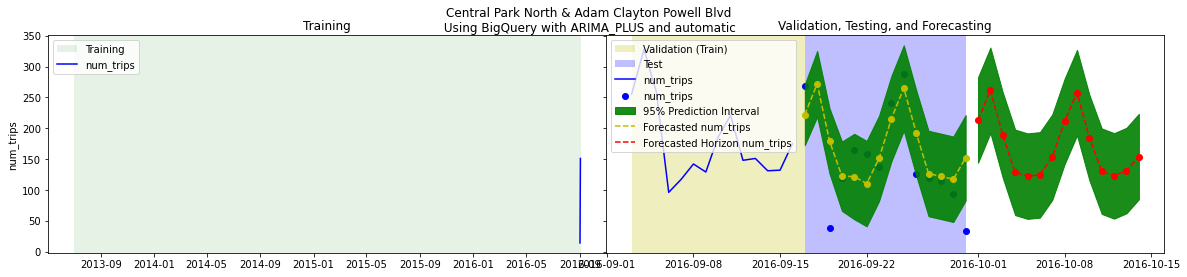

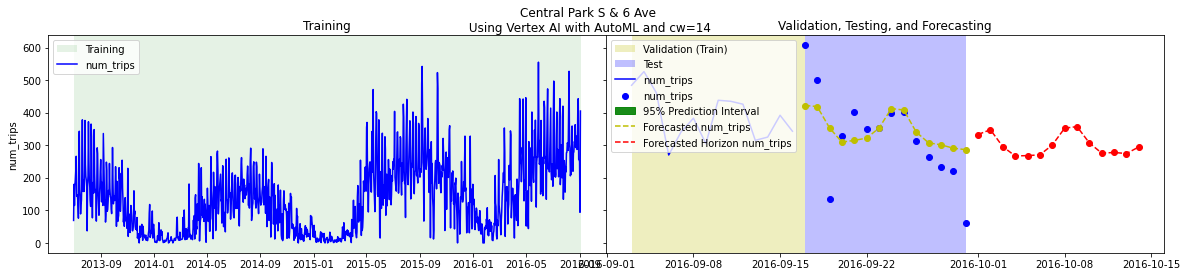

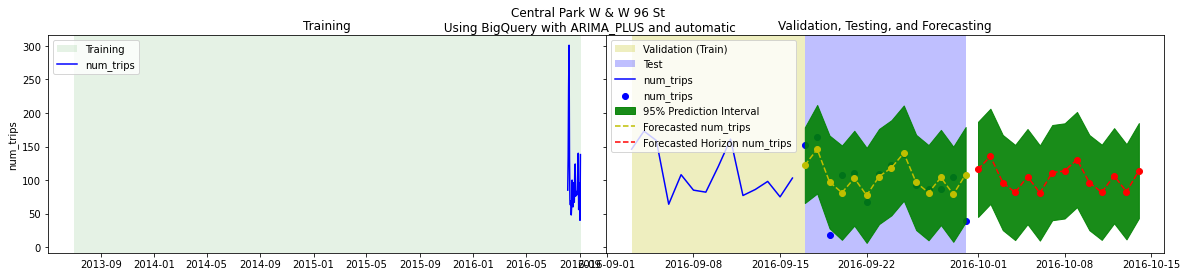

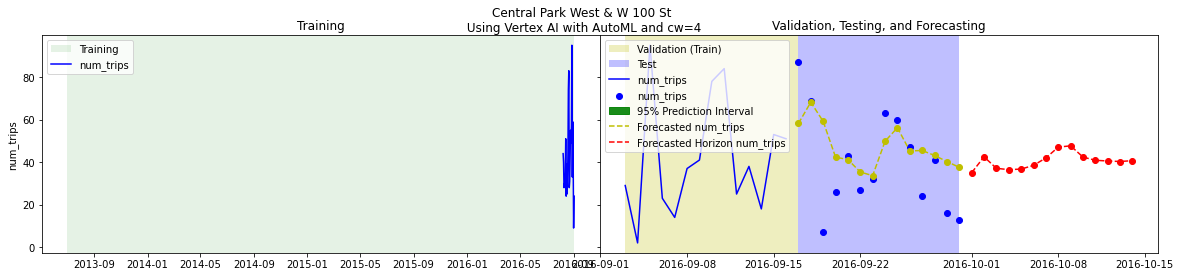

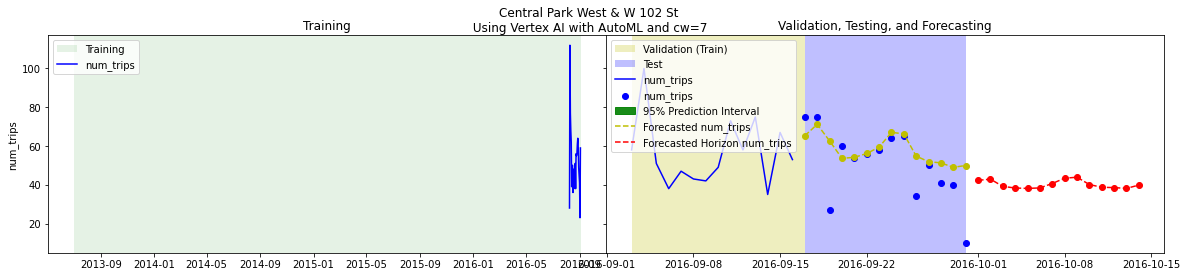

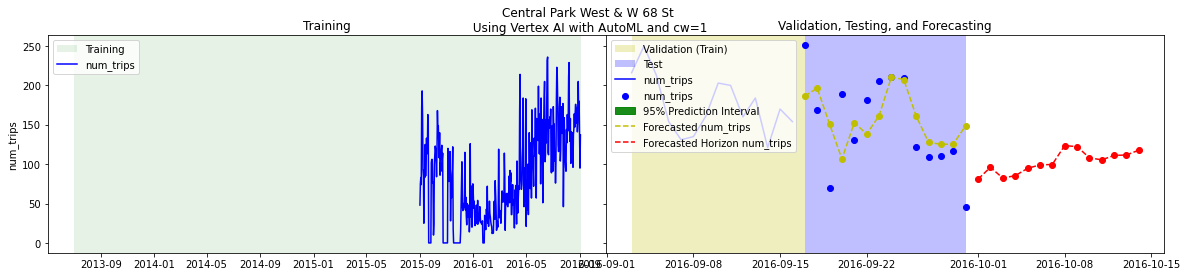

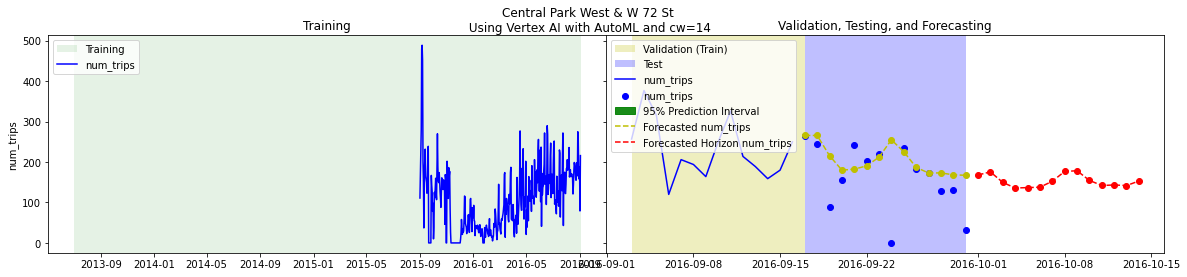

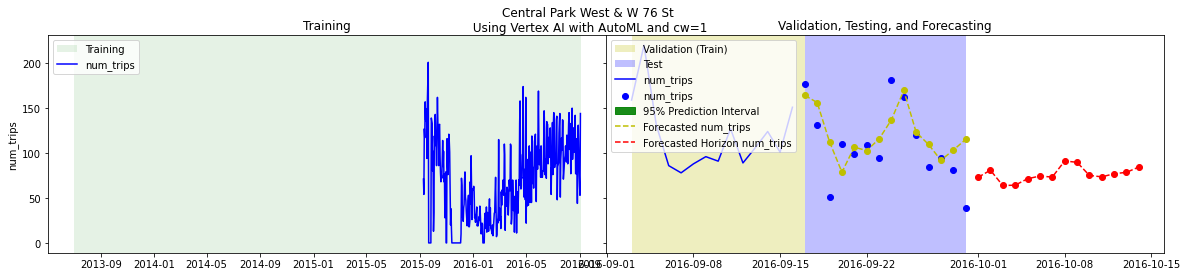

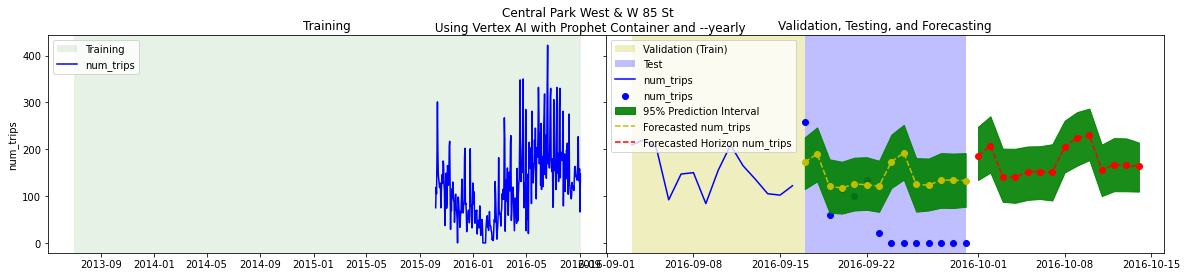

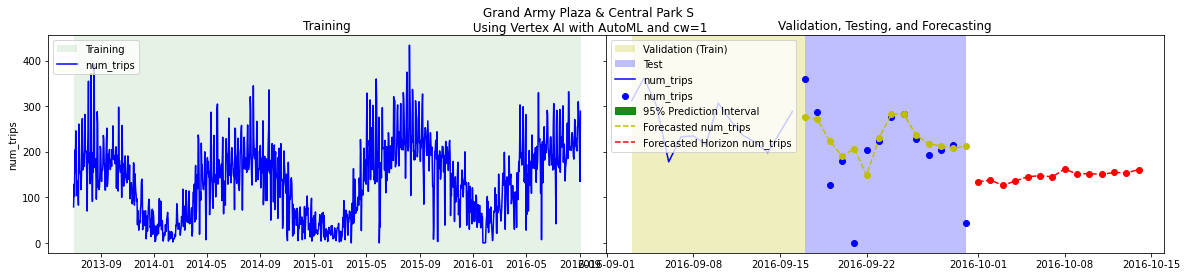

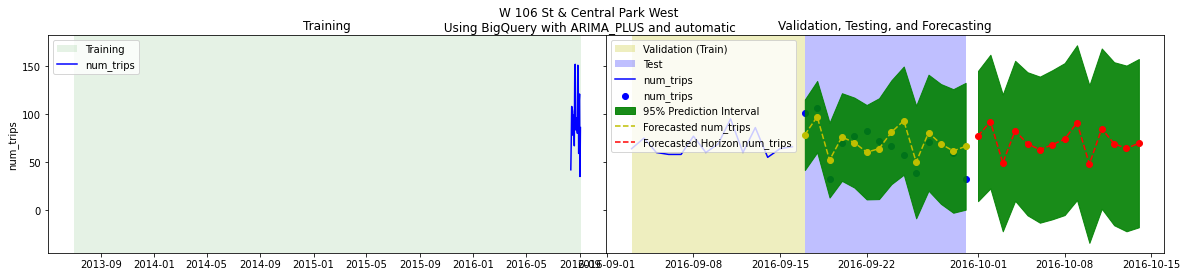

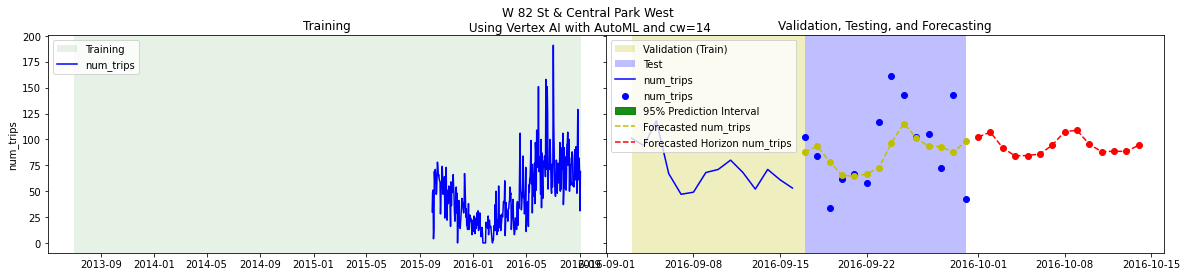

In [47]:
series = champion[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = champion[(champion[SERIES_COLUMN] == st) & (champion['splits'] == 'TRAIN')]
    valdf = champion[(champion[SERIES_COLUMN] == st) & (champion['splits'] == 'VALIDATE')]
    testdf = champion[(champion[SERIES_COLUMN] == st) & (champion['splits'] == 'TEST')]
    horizondf = champion[(champion[SERIES_COLUMN] == st) & (champion['splits'] == 'HORIZON')]
    #fit_testdf = fitSeries[(fitSeries[SERIES_COLUMN] == st)]
    #horizondf = horizon[(horizon[SERIES_COLUMN] == st)]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # plot raw time series
    axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = TARGET_COLUMN)
    axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = TARGET_COLUMN)
    axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = TARGET_COLUMN)
    
    # plot fitted test data
    axes[1].fill_between(testdf[TIME_COLUMN], testdf['yhat_lower'], testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].plot(testdf[TIME_COLUMN], testdf['yhat'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')
    axes[1].scatter(testdf[TIME_COLUMN], testdf['yhat'], color = 'y')
    
    axes[1].fill_between(horizondf[TIME_COLUMN], horizondf['yhat_lower'], horizondf['yhat_upper'], color = 'g', alpha = 0.9)
    axes[1].plot(horizondf[TIME_COLUMN], horizondf['yhat'], color = 'r', label = f'Forecasted Horizon {TARGET_COLUMN}', linestyle='dashed')
    axes[1].scatter(horizondf[TIME_COLUMN], horizondf['yhat'], color = 'r')
    
    # labels
    axes[0].set_ylabel(TARGET_COLUMN)
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    
    # title
    platform, method, scenario = champion[(champion[SERIES_COLUMN] == st) & (champion['splits'] == 'HORIZON')][['platform','method','scenario']].iloc[0]
    plt.suptitle(st + f"\n Using {platform} with {method} and {scenario}")

    # display result
    plt.show()

## Results - Compare

In [48]:
champion_overall = bigquery.query(query = f"SELECT * FROM `{PROJECT_ID}.{BQ_DATASET}.champion_overall`").to_dataframe()
champion_series = bigquery.query(query = f"SELECT * FROM `{PROJECT_ID}.{BQ_DATASET}.champion_series`").to_dataframe()
champion_ensemble = bigquery.query(query = f"SELECT * FROM `{PROJECT_ID}.{BQ_DATASET}.champion_ensemble`").to_dataframe()

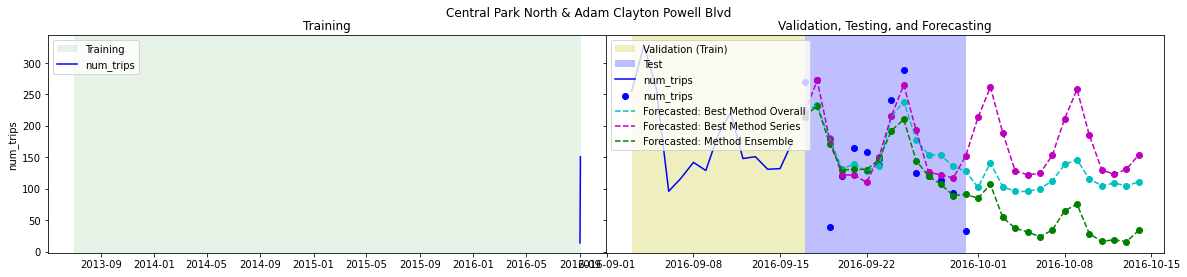

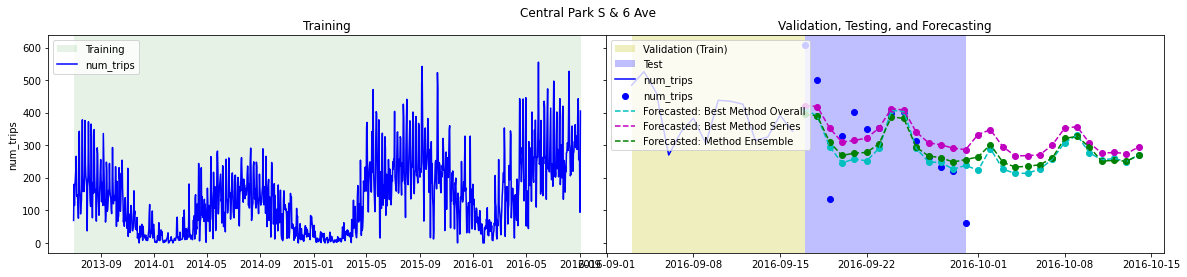

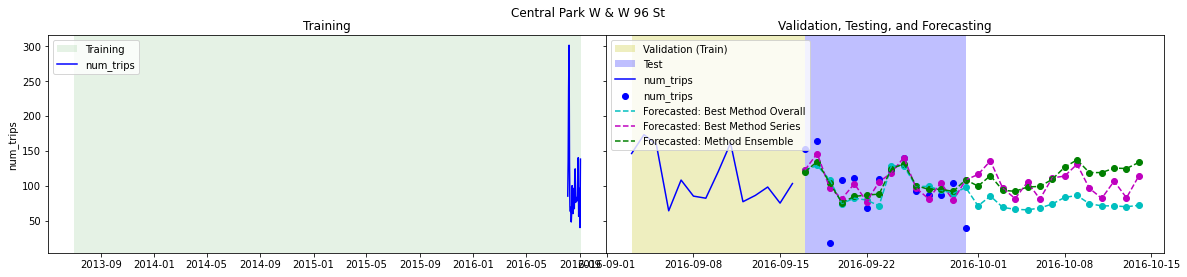

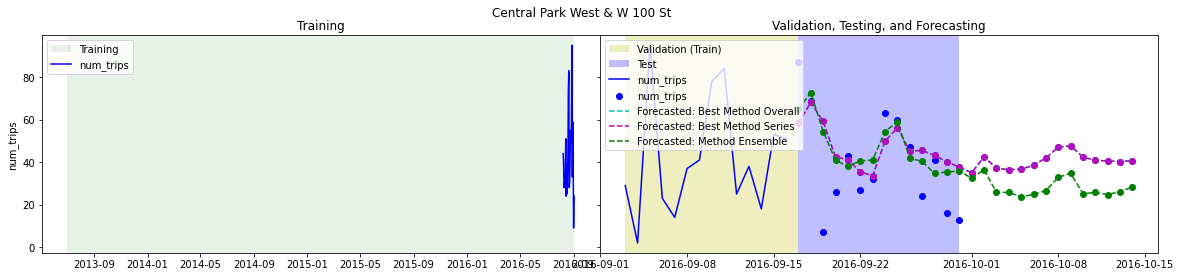

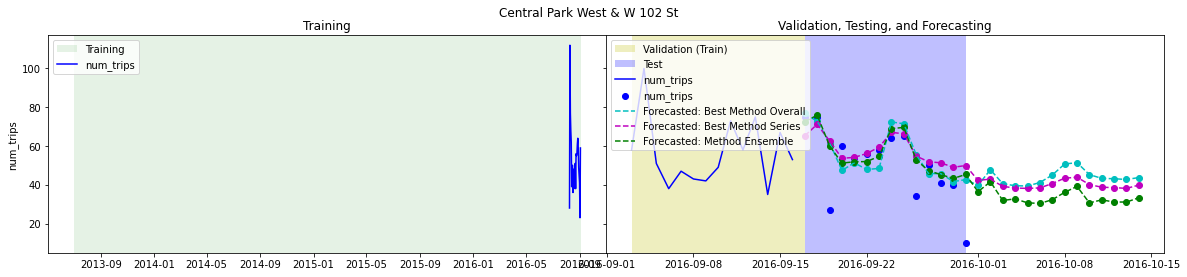

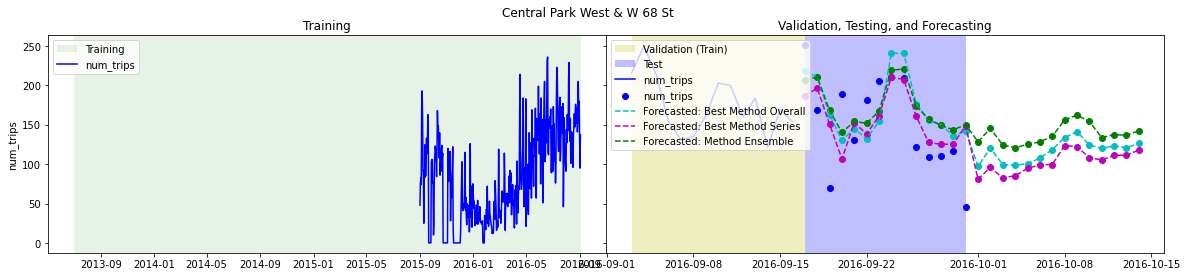

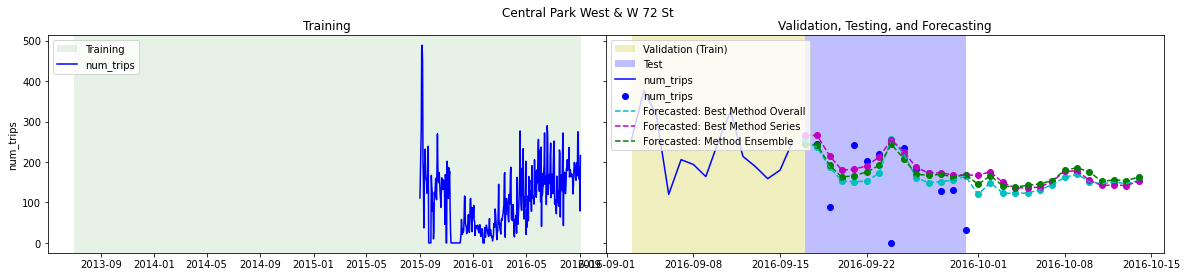

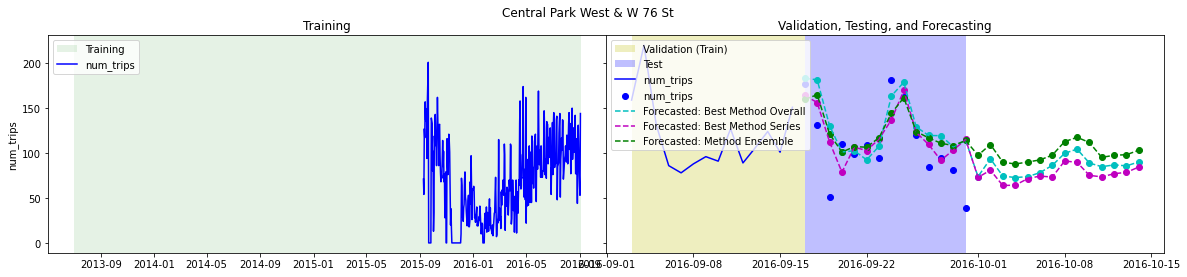

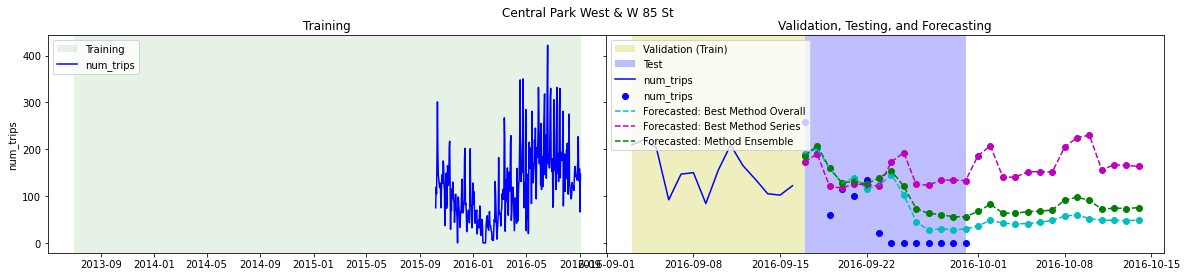

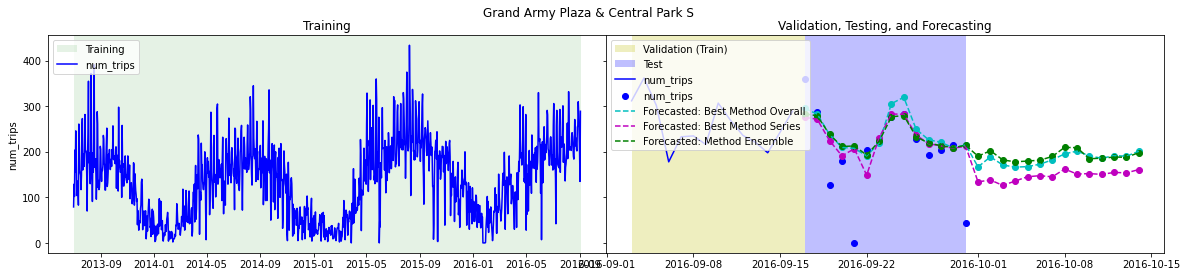

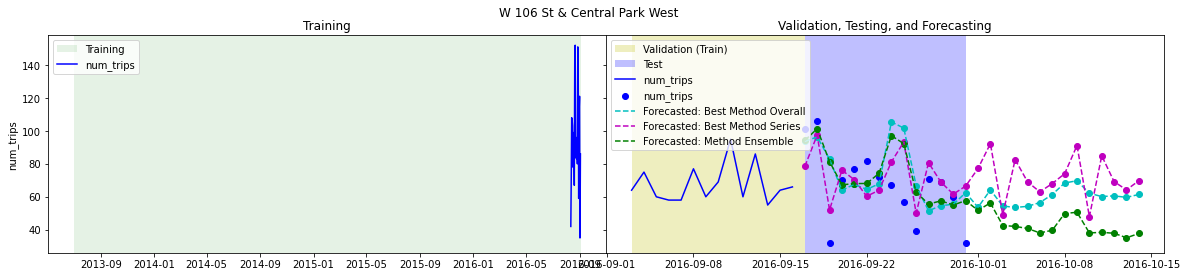

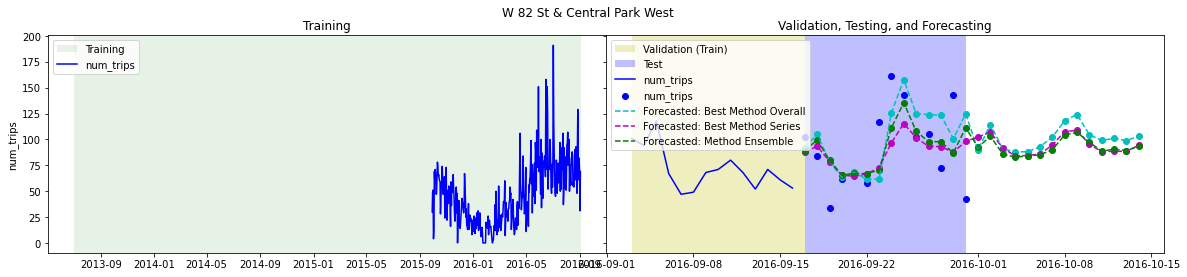

In [49]:
series = champion_overall[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = champion_overall[(champion_overall[SERIES_COLUMN] == st) & (champion_overall['splits'] == 'TRAIN')]
    valdf = champion_overall[(champion_overall[SERIES_COLUMN] == st) & (champion_overall['splits'] == 'VALIDATE')]
    testdf = champion_overall[(champion_overall[SERIES_COLUMN] == st) & (champion_overall['splits'] == 'TEST')]
    
    overall = champion_overall[(champion_overall[SERIES_COLUMN] == st) & (champion_overall['splits'].isin(['TEST', 'HORIZON']))]
    series = champion_series[(champion_series[SERIES_COLUMN] == st) & (champion_series['splits'].isin(['TEST', 'HORIZON']))]
    ensemble = champion_ensemble[(champion_ensemble[SERIES_COLUMN] == st) & (champion_ensemble['splits'].isin(['TEST', 'HORIZON']))]
        
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # plot raw time series
    axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = TARGET_COLUMN)
    axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = TARGET_COLUMN)
    axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = TARGET_COLUMN)
    
    # plot fitted test data
    axes[1].plot(overall[TIME_COLUMN], overall['yhat'], color = 'c', label = f'Forecasted: Best Method Overall', linestyle='dashed')
    axes[1].scatter(overall[TIME_COLUMN], overall['yhat'], color = 'c')
    axes[1].plot(series[TIME_COLUMN], series['yhat'], color = 'm', label = f'Forecasted: Best Method Series', linestyle='dashed')
    axes[1].scatter(series[TIME_COLUMN], series['yhat'], color = 'm')
    axes[1].plot(ensemble[TIME_COLUMN], ensemble['yhat'], color = 'g', label = f'Forecasted: Method Ensemble', linestyle='dashed')
    axes[1].scatter(ensemble[TIME_COLUMN], ensemble['yhat'], color = 'g')
    
    # labels
    axes[0].set_ylabel(TARGET_COLUMN)
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    
    # title
    platform, method, scenario = champion_series[(champion_series[SERIES_COLUMN] == st) & (champion_series['splits'] == 'HORIZON')][['platform','method','scenario']].iloc[0]
    plt.suptitle(st)# + f"\n Using {platform} with {method} and {scenario}")

    # display result
    plt.show()